In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import nltk
import seaborn as sns
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Processing original validation sheets
Only do once

In [3]:
# path_to_validation_sheets = r"Validacion de Textos - ChatGPT\wikipedia_validation_sheets_original"
# path_to_save_new_validation_files = r"Validacion de Textos - ChatGPT\Validation Files - Preprocessed"
# column_names = ["Number", "Wikipedia Term", "Metamap Term", "Semantic Type from Metamap", "TVP Validation", "Wikipedia DISNET Validation",
#                 "Metamap DISNET Validation", "TVP DISNET Validation", "Relevant DISNET Validation"]
# columns_to_strip = ["Semantic Type from Metamap", "TVP Validation", "Wikipedia DISNET Validation", 
#                     "Metamap DISNET Validation", "TVP DISNET Validation", "Relevant DISNET Validation"]
# # Looping through all the files in the folder of the original validation sheets
# for file in os.listdir(path_to_validation_sheets):
#     if file.endswith(".xlsx"):
#         df = pd.read_excel(os.path.join(path_to_validation_sheets, file), sheet_name=0)
#         df.columns = column_names # Setting the column names
#         first_number = df["Number"].first_valid_index() # Getting the index of the first valid number
#         df = df.iloc[first_number:] # Removing the rows before the first valid number
#         # Remove the rows that have all NaN values
#         df = df.dropna(how="all")
#         # Drop the Number column
#         df = df.drop(columns=["Number"])
#         # Strip the columns
#         for column in columns_to_strip:
#             df[column] = df[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
#         # Remove the commas from the Wikipedia Term column
#         df["Wikipedia Term"] = df["Wikipedia Term"].apply(lambda x: x.replace(",", "") if isinstance(x, str) else x)
#         # Saving the new validation file into the path_to_save_new_validation_files
#         new_name = file.replace("VALIDATION", "VALIDATION_PREPROCESSED")
#         df.to_excel(os.path.join(path_to_save_new_validation_files, new_name), index=False)

# UMLS API Usage functions definition

In [4]:
import time
import requests

counter = 0

def term2cui(string):
    """
    This function receives a term string and returns a list of concepts that are related to the term string according to the UMLS.
    """
    global counter

    counter += 1

    if counter % 1000 == 0:
        print("\n\t\tSleeping 10 secs")
        time.sleep(10)
    
    apikey = 'b006f1da-d798-4ee3-a539-cce03b14b68f'
    version = 'current'
    uri = "https://uts-ws.nlm.nih.gov"
    content_endpoint = "/rest/search/"+version
    full_url = uri+content_endpoint
    search_type = 'exact'
    page = 0
    
    result = list()

    try:
        while True:
            page += 1
            query = {'string':string,'apiKey':apikey, 'pageNumber':page, 'searchType':search_type}
            r = requests.get(full_url,params=query)
            r.raise_for_status()
            r.encoding = 'utf-8'
            outputs  = r.json()
        
            items = (([outputs['result']])[0])['results']
            
            if len(items) == 0:
                if page == 1:
                    break
                else:
                    break
            
            for item in items:
                # result.append(tuple([item['ui'], item['name']])) # These are the CUIs, names
                result.append(item['name']) # These are only the names
            # Transform the list into a single text string
            result = ', '.join(result)

    except Exception as except_error:
        print(except_error)    
    
    if len(result) == 0:
        return 'NaN'
    
    return result

def cui2sty(cui):

    apikey = 'b006f1da-d798-4ee3-a539-cce03b14b68f'
    version = 'current'
    uri = "https://uts-ws.nlm.nih.gov"        
    path = '/content/'+version+'/CUI/'+cui

    try:
        query = {'apiKey':apikey}
        r = requests.get(uri+path, params=query)
        r.raise_for_status()
        r.encoding = 'utf-8'
        outputs  = r.json()
            
        items = outputs['result']
        result = items['semanticTypes'][0]['name'] 

    except Exception as except_error:
        print(except_error)

        try:
            query = {'apiKey':apikey}
            r = requests.get(uri+path, params=query)
            r.raise_for_status()
            r.encoding = 'utf-8'
            outputs  = r.json()
                
            items = outputs['result']
            result = items['semanticTypes'][0]['name'] 

        except Exception as except_error:
            print(except_error)
            result = 'NaN'

    return result

# Generating the data with the International Classification of Diseases (ICD)

Only do once

In [5]:
# path_to_ICD_9_categories = r"[TFM - MUCD] Textos de las enfermedades\disease_ICD_categories.csv"
# path_to_disease_text_info = r"[TFM - MUCD] Textos de las enfermedades\Disease_Texts_Information.xlsx"
# # Load the ICD-9 categories into a DataFrame
# df_ICD_9_categories = pd.read_csv(path_to_ICD_9_categories)
# # Load the disease text information into a DataFrame
# df_disease_text_info = pd.read_excel(path_to_disease_text_info)
# print(df_ICD_9_categories.columns)
# print(df_disease_text_info.columns)

# # Merge the two DataFrames on name and disease_name
# df_merge = pd.merge(df_ICD_9_categories, df_disease_text_info, left_on="name", right_on="Disease_name", how="right")

# # Save the merged DataFrame into a new Excel file
# df_merge.to_excel(r"[TFM - MUCD] Textos de las enfermedades\Disease_Texts_Information_Merged.xlsx", index=False)


# Adding a column that contains an updated metamap term and the wikipedia terms which have their column empty, are tried to be filled out.
Only do once

In [6]:
# path_to_save_new_validation_files = r"Validacion de Textos - ChatGPT\Validation Files - Preprocessed"
# path_to_save_new_validation_files_metamap_updated = r"Validacion de Textos - ChatGPT\Validation Files - Metamap Updated Column"
# # Looping through all the files in the folder of the preprocessed validation sheets
# for file in os.listdir(path_to_save_new_validation_files):
#     if file.endswith(".xlsx"):
#         df = pd.read_excel(os.path.join(path_to_save_new_validation_files, file), sheet_name=0)
#         # Create a new column that will contain an updated Metadata Term
#         # if the Metamap Term column is empty, then use the Wikipedia Term column to generate the CUI term

#         # Select the term that will be used to generate the updated CUI term
#         df["Metamap Term Updated"] = np.where(df["Metamap Term"].isna(), df["Wikipedia Term"], df["Metamap Term"])
#         # Apply the term2cui function to the Metamap Term Updated column
#         df["Metamap Term Updated"] = df["Metamap Term Updated"].apply(lambda x: term2cui(x) if isinstance(x, str) else x)
#         # if the Metamap Term Updated column contains "NaN", meaning that the term2cui function didn't return a result, then repeat the Wikipedia Term column
#         df["Metamap Term Updated"] = np.where(df["Metamap Term Updated"] == "NaN", df["Wikipedia Term"], df["Metamap Term Updated"])
#         # Save the updated validation file
#         file = file.replace("VALIDATION_PREPROCESSED", "VALIDATION_PREPROCESSED_METAMAP_UPDATED")
#         df.to_excel(os.path.join(path_to_save_new_validation_files_metamap_updated, file), index=False)

In [7]:
# import os
# import pandas as pd
# import numpy as np
# path_mini_analyze = r"Resultados de Prompts\GPT35turbo\Prompt 2"
# # Loop through all the files in the folder
# temp_df = pd.DataFrame()
# for file in os.listdir(path_mini_analyze):
#     if file.endswith(".xlsx"):
#         df = pd.read_excel(os.path.join(path_mini_analyze, file), sheet_name=0)
#         TUI_df = df[['TUI_Code', 'Semantic_Type']].drop_duplicates()
#         # Addd the TUI_df to the temp_df
#         temp_df = pd.concat([temp_df, TUI_df])

# # Remove the duplicates from the temp_df
# temp_df = temp_df.drop_duplicates()
# # Save the temp_df into a new excel file
# temp_df.to_excel(os.path.join(r"Resultados de Prompts\GPT35turbo", "TUI_Codes_Semantic_Types.xlsx"), index=False)

# Replacing characters in name of files that do not match
Auxiliary function

In [8]:
# def fix_file_list(path: str):
#     """
#     This function receives a path to a folder and changes the name of the files in the folder that have ÔÇô for a –
#     """
#     for filename in os.listdir(path):
#         if "ÔÇô" in filename:
#             new_filename = filename.replace("ÔÇô", "–")
#             os.rename(os.path.join(path, filename), os.path.join(path, new_filename))

# # Only need to run this once
# # prompt_results = r"Resultados de Prompts"
# # prompt_number = range(1, 7)
# # for prompt_number in prompt_number:
# #     prompt_folder = os.path.join(prompt_results, f"Prompt {prompt_number}")
# #     fix_file_list(prompt_folder)

# Setting up BioBERT (needed)

In [2]:
# Loading BioBERT model and tokenizer
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# # Load ClinicalBioBERT tokenizer and model, optional, probably has better performance for clinical text
# tokenizer_clinical = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
# model_clinical = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(device)
# Load BioBERT tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
# model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1").to(device)

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(device)


def get_embedding(term):
    """
    This function receives a string term and returns its embedding using the BioBERT model.
    """
    try:
        # Tokenize the term and get input IDs and attention mask, move to GPU
        inputs = tokenizer(term, return_tensors="pt", truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        # Get the embeddings from the model's output
        embeddings = outputs.last_hidden_state
        # Mean pooling to get a single embedding vector for the term
        embedding = torch.mean(embeddings, dim=1).squeeze()
        return embedding.cpu().numpy()  # Move back to CPU for compatibility with sklearn
    except Exception as e:
        print(f"Error getting embedding for term '{term}': {e}")
        return None

def calculate_similarity_BioBERT(term1, term2):
    """
    This function receives two terms and returns their cosine similarity using BioBERT embeddings.
    calculate_similarity_BioBERT(GPT_term, wiki_term) >= 0.95 is a good indicator that the terms are similar.
    """
    # Get embeddings for both terms
    embedding1 = get_embedding(term1)
    embedding2 = get_embedding(term2)

    # Ensure both embeddings are valid
    if embedding1 is None or embedding2 is None:
        return 0
    
    # Calculate cosine similarity
    similarity = cosine_similarity([embedding1], [embedding2])
    return similarity[0][0]

def find_most_similar_term(term, list_of_terms):
    """
    This function receives a term and a list of terms, and returns the term from the list that is most similar to the input term.
    The function is not used in the pipeline, it was created as an auxiliary function for testing.
    """
    # Calculate similarity of the term with all terms
    similarities = [calculate_similarity_BioBERT(term, other_term) for other_term in list_of_terms]
    # Find the index of the term with highest similarity
    most_similar_idx = np.argmax(similarities)
    return list_of_terms[most_similar_idx], similarities[most_similar_idx]

Using device: cuda


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

c:\Users\marce\anaconda3\envs\qualentumEnv\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\marce\.cache\huggingface\hub\models--emilyalsentzer--Bio_ClinicalBERT. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

# Functions to evaluate the results of the prompts (needed)

In [3]:
# Loading the list of stopwords
stop_words = set(stopwords.words('english'))
def calc_levenstein_distance(term1, term2):
    """
    This function calculates the Levenshtein distance between two terms. The Levenshtein distance is the number of single-character edits
    (insertions, deletions, or substitutions) required to change one word into the other. Substitution cost is 1 and transpositions are not allowed.
    """
    return nltk.edit_distance(term1, term2, substitution_cost=1, transpositions=False)
def remove_stopwords(text):
    """
    This function receives a text and removes the stopwords from the text, returning a list of words without the stopwords.
    """
    global stop_words
    # Tokenize the text
    word_tokens = word_tokenize(text)
    # Filter out stopwords
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return filtered_text
def strict_string_matching(evaluation_df, validation_df, prompt_df):
    """
    This function receives the evaluation_df, validation_df, and prompt_df. It will match the terms in the GPT results with the terms in the validation file
    using a strict string matching approach in conjunction with a Levenshtein distance of 1. It will return the evaluation_df, validation_df, prompt_df, and prompt_df_scratch.
    The matched terms will be removed from the prompt_df_scratch and the validation_df. Evaluation_df and prompt_df will contain the matched terms. 
    """
    prompt_df_scratch = prompt_df.copy()
    for validation_index, wiki_term, metamap_term, metamapUpdated_term, wikiMetamap_joined in validation_df.itertuples(index=True):
        for GPT_index, GPT_term in prompt_df_scratch["GPT_Term_lower"].items():
            # if the distance between the terms is 1 or less, then the terms are considered a match
            if calc_levenstein_distance(wiki_term, GPT_term) <= 1:
                # Add the data from the prompt result to the evaluation_df
                data_GPT_Entity = prompt_df.iloc[GPT_index]
                for column in data_GPT_Entity.index:
                    evaluation_df.loc[validation_index, column] = data_GPT_Entity[column]
                # Mark the row as matched in the prompt_df and add the wiki term that matched
                prompt_df.loc[GPT_index, "isMatchedbyString"] = "YES"
                prompt_df.loc[GPT_index, "Matched_Wiki_Term"] = wiki_term
                prompt_df.loc[GPT_index, "Matched_Metamap_Term"] = metamap_term
                prompt_df.loc[GPT_index, "Matched_Metamap_Term_Updated"] = metamapUpdated_term
                # Remove the matched term from the prompt_df_scratch
                try:
                    prompt_df_scratch = prompt_df_scratch.drop(index=GPT_index)
                except Exception as e:
                    print(e)
                    display(prompt_df_scratch)
                    # Stop the program if there is an error
                    raise
                # Remove the matched term from the validation_df
                validation_df = validation_df.drop(index=validation_index)
                break
    return evaluation_df, validation_df, prompt_df, prompt_df_scratch
def isInString(short_string, long_string):
    """Check if all words in a small string are present in a longer string.
    Example: small_string = "stomach pain", long_string = "stomach discomfort and pain"
    Example: small_string = "yellow fever", long_string = "yellow skin or fever"
    isInString(term1, term2) -> True
    It also uses the Levenshtein distance to check if the words are in the long string with a distance of 1.
    When using the distance, it will remove the stopwords from both set of strings before analyzing the words.
    """
    if short_string == "Empty Value - don't use" or long_string == "Empty Value - don't use":
        return False # if the short_string or long_string is an empty value, return False
    if short_string in long_string: # if the small string is in the long string without any distance or calculation
        return True
    # Split the small string into words separated by spaces
    short_string_words = short_string.split()
    # Check if all words in the small string are in the long string but in any order
    match_without_distance = all(small_word in long_string for small_word in short_string_words)
    if match_without_distance:
        return True
    # If the words are not in the long string, check if the words are in the long string with a Levenshtein distance of 1
    # Split the long string into words separated by spaces
    # long_string_words = long_string.split()
    long_string_words = remove_stopwords(long_string)
    short_string_words = remove_stopwords(short_string)
    # Check if all words in the small string are in the long string with a Levenshtein distance of 1, after removing the stopwords
    match_with_distance = all(any(calc_levenstein_distance(small_word, long_word) <= 1 for long_word in long_string_words) for small_word in short_string_words)
    return match_with_distance
def add_TUI_Abbreviation(df: pd.DataFrame):
    """
    This function receives a DataFrame that contains the column TUI code which was assigned by ChatGPT. It will add the TUI abbreviation and the Semantic Type from the
    actual TUI code and semantic type tables by using the TUI code as matching key. It will return the DataFrame with the added columns.
    """
    TUI_abbreviation_path = r"List of all TUI Codes, Semantic Types, and Abbreviation.txt"
    # Open the TUI_abbreviation as a df
    columns = ["Abbreviation_Semantic_Type_from_matching_TUI_Code", "TUI_Code", "Semantic_Type_from_Text_from_matching_TUI_Code"]
    TUI_df = pd.read_csv(filepath_or_buffer=TUI_abbreviation_path, sep="|")
    TUI_df.columns = columns
    # Join the df with the TUI_df using a left join based on the TUI_Code column
    df = pd.merge(df, TUI_df, left_on="TUI_Code", right_on="TUI_Code", how="left")
    return df
def evaluate_result_string2string(path_to_folder_prompt_results):
    """
    This function receives a path to a folder that contains the results of a prompt. It will evaluate the results of the prompt
    by comparing the terms in the GPT results with the terms in the validation files using multiples string approaches. It will create a new evaluation
    file for each prompt GPT result file. The evaluation file will contain the terms in the validation file that match with the
    terms in the GPT result file. It will also contain the terms that don't match. A file per prompt will be saved in the folder.
    """
    folder_name = path_to_folder_prompt_results.split("\\")[-1] # Getting the name of the folder prompt results, e.g. Prompt 2
    model_name = path_to_folder_prompt_results.split("\\")[-2] # Getting the name of the model, e.g. GPT35turbo
    path_to_evaluation_files = r"Validacion de Textos - ChatGPT\Evaluation Files" # where the evaluation files will be saved in general
    model_name_saved_path = os.path.join(path_to_evaluation_files, model_name) # Path to save the summary evaluation files
    path_to_evaluation_files_of_prompt = os.path.join(path_to_evaluation_files, model_name, folder_name) # Path to save each evaluation file excel per disease
    abbreviation = folder_name.split(" ")[1] # e.g. 2 or 2_simplified
    abbreviation = "P" + abbreviation # e.g. P2 or P2_simplified

    # If final path to save the evaluation files doesn't exist, create it
    if not os.path.exists(path_to_evaluation_files_of_prompt):
        os.makedirs(path_to_evaluation_files_of_prompt)
        print(f"Creating folder: {path_to_evaluation_files_of_prompt}")

    # Create a list of the files in the validation folder that will be used to compare the results of the prompt
    path_to_validation_files = r"Validacion de Textos - ChatGPT\Validation Files - Metamap Updated Column"
    validation_files = os.listdir(path_to_validation_files)

    # Create a list with the files that have already been evaluated
    evaluated_files = [file.split("_")[0] for file in os.listdir(path_to_evaluation_files_of_prompt) if file.endswith(".xlsx")]
    # Check if the evaluated_files is empty
    print(f"Analyzing: {path_to_folder_prompt_results}")
    # Start a progress bar that shows the progress of the evaluation

    for file in tqdm(os.listdir(path_to_folder_prompt_results), desc="Analyzing files"):
        # Extract the name of the disease from the file
        file_name = file.split("_")[0]
        # Skip the file if it has already been analyzed
        if file_name in evaluated_files:
            continue
        if file.endswith(".xlsx"):
            # Open the prompt result file
            prompt_df = pd.read_excel(os.path.join(path_to_folder_prompt_results, file), sheet_name=0)
            # Add the TUI abbreviation to the prompt_df
            prompt_df = add_TUI_Abbreviation(prompt_df)
            # Rename the Entity column to GPT Term
            prompt_df = prompt_df.rename(columns={"Entity": "GPT_Term"})
            prompt_df["GPT_Term_lower"] = prompt_df["GPT_Term"].str.lower()
            # Open the corresponding validation file
            validation_file_name = [vf for vf in validation_files if file_name in vf]
            if len(validation_file_name) == 0:
                print(f"Validation file for {file_name} not found.")
                continue
            validation_file_name = validation_file_name[0]
            validation_file_full_name = os.path.join(path_to_validation_files, validation_file_name)
            validation_df = pd.read_excel(validation_file_full_name, sheet_name=0)
            # Replace the NaN values in the Metamap Term column from the validation file with an empty string
            validation_df["Metamap Term"] = validation_df["Metamap Term"].replace(np.nan, '', regex=True)
            # Add a column to the validation file that merges the columns Wikipedia Term, Metamap Term and the Metamap Term Updated
            validation_df["Wikipedia and Metamap Term - Joined"] = (validation_df["Wikipedia Term"] + ", "
                                                                    + validation_df["Metamap Term"] + ", "
                                                                    + validation_df["Metamap Term Updated"])
            evaluation_df = validation_df.copy() # Creating a copy of the validation_df to store the evaluation results
            comparison_columns = ["Wikipedia Term", "Metamap Term", "Metamap Term Updated", "Wikipedia and Metamap Term - Joined"]
            validation_df = validation_df[comparison_columns] # Only keep the columns that will be used for the comparison
            # Remove "NOS", apply lower case, remove commas, blank space endings, and any additional blank space in from the comparison columns in the validation df
            for column in comparison_columns:
                validation_df[column] = validation_df[column].apply(lambda x: x.replace("NOS", "") if isinstance(x, str) else x)
                validation_df[column] = validation_df[column].apply(lambda x: x.replace(",", "") if isinstance(x, str) else x)
                validation_df[column] = validation_df[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
                validation_df[column] = validation_df[column].apply(lambda x: x.lower() if isinstance(x, str) else x)
                # TO_DO agregar mas preprocesado de acentos, hyphens, etc
                # Remove any additional space in between words if there are two or more spaces
                validation_df[column] = validation_df[column].apply(lambda x: " ".join(x.split()) if isinstance(x, str) else x)
            
            # Finding if the terms in the prompt are in the validation file
            # First, matching if the terms are in the validation file with a distance of 1, strictly matching the terms
            evaluation_df, validation_df, prompt_df, prompt_df_scratch = strict_string_matching(evaluation_df, validation_df, prompt_df)
            for GPT_index, GPT_term in prompt_df_scratch["GPT_Term_lower"].items():
                isFoundGPTTerm = False
                # Looping each prompt result through the terms in the validation file
                for validation_index, wiki_term, metamap_term, metamapUpdated_term, wikiMetamap_joined in validation_df.itertuples(index=True):
                    # If the metamap_term in the validation file is empty, replace it with a string that is not in the GPT term
                    metamap_term = "Empty Value - don't use" if metamap_term == "" else metamap_term
                    # Matching terms between the GPT term and the validation file
                    if isInString(GPT_term, wikiMetamap_joined) or isInString(wiki_term, GPT_term) or \
                        isInString(metamap_term, GPT_term) or isInString(metamapUpdated_term, GPT_term):
                        isFoundGPTTerm = True
                        prompt_df.loc[GPT_index, "isMatchedbyString"] = "YES"
                    # elif calculate_similarity_BioBERT(GPT_term, wiki_term) >= 0.95:
                    #     isFoundGPTTerm = True
                    #     prompt_df.loc[GPT_index, "isMatchedbyBioBERT"] = "YES"
                    if isFoundGPTTerm: # If the term was found in the validation file
                        data_GPT_Entity = prompt_df.iloc[GPT_index] # Get the data from the prompt result
                        for column in data_GPT_Entity.index: # Add the data from the prompt result to the evaluation_df
                            evaluation_df.loc[validation_index, column] = data_GPT_Entity[column]
                        # Mark the row as matched in the prompt_df and add the wiki term that matched
                        prompt_df.loc[GPT_index, "Matched_Wiki_Term"] = wiki_term
                        prompt_df.loc[GPT_index, "Matched_Metamap_Term"] = metamap_term
                        prompt_df.loc[GPT_index, "Matched_Metamap_Term_Updated"] = metamapUpdated_term
                        # Remove the matched term from the prompt_df_scratch and the validation_df
                        prompt_df_scratch = prompt_df_scratch.drop(index=GPT_index)
                        validation_df = validation_df.drop(index=validation_index)
                        break # Stop the loop if the term was found
                # If the term was not found in the validation file, mark it as NO
                if not isFoundGPTTerm: 
                    prompt_df.loc[GPT_index, "isMatchedbyString"] = "NO"
            
            # Looping again to use BioBERT AFTER the string matching is done, it's less computationally expensive because we
            # don't have to use BioBERT for all terms that weren't matched by string
            for GPT_index, GPT_term in prompt_df_scratch["GPT_Term_lower"].items():
                isFoundGPTTerm = False
                # Looping each prompt result through the terms in the validation file
                for validation_index, wiki_term, metamap_term, metamapUpdated_term, wikiMetamap_joined in validation_df.itertuples(index=True):
                    # If the metamap_term in the validation file is empty, replace it with a string that is not in the GPT term
                    metamap_term = "Empty Value - don't use" if metamap_term == "" else metamap_term
                    # Matching terms between the GPT term and the validation file
                    if calculate_similarity_BioBERT(GPT_term, wiki_term) >= 0.95:
                        isFoundGPTTerm = True
                        prompt_df.loc[GPT_index, "isMatchedbyBioBERT"] = "YES"
                        prompt_df.loc[GPT_index, "isMatchedbyString"] = "YES"
                        data_GPT_Entity = prompt_df.iloc[GPT_index] # Get the data from the prompt result
                        for column in data_GPT_Entity.index: # Add the data from the prompt result to the evaluation_df
                            evaluation_df.loc[validation_index, column] = data_GPT_Entity[column]
                        # Mark the row as matched in the prompt_df and add the wiki term that matched
                        prompt_df.loc[GPT_index, "Matched_Wiki_Term"] = wiki_term
                        prompt_df.loc[GPT_index, "Matched_Metamap_Term"] = metamap_term
                        prompt_df.loc[GPT_index, "Matched_Metamap_Term_Updated"] = metamapUpdated_term
                        # Remove the matched term from the prompt_df_scratch and the validation_df
                        prompt_df_scratch = prompt_df_scratch.drop(index=GPT_index)
                        validation_df = validation_df.drop(index=validation_index)
                        break # Stop the loop if the term was found
                # If the term was not found in the validation file, mark it as NO
                if not isFoundGPTTerm:
                    prompt_df.loc[GPT_index, "isMatchedbyBioBERT"] = "NO"
                    prompt_df.loc[GPT_index, "isMatchedbyString"] = "NO"
                
            # Save the evaluation_df
            evaluation_file_name = file_name + f"_{abbreviation}_Evaluation.xlsx"
            evaluation_path = os.path.join(path_to_evaluation_files_of_prompt, evaluation_file_name)
            # Drop the columns that are not needed in the evaluation_df
            evaluation_df = evaluation_df.drop(columns=["Wikipedia and Metamap Term - Joined"])
            evaluation_df.to_excel(evaluation_path, index=False, sheet_name="Evaluation Results")
            # Save the prompt_df in the same excel but in a different sheet
            with pd.ExcelWriter(evaluation_path, engine="openpyxl", mode="a") as writer:
                prompt_df.drop(columns=["GPT_Term_lower"]).to_excel(writer, index=False, sheet_name="Prompt Results")
    return model_name_saved_path
def calculate_metrics_of_df(evaluation_df: pd.DataFrame, prompt_df: pd.DataFrame, file_name: str):
    """
    This function receives the evaluation_df, prompt_df, and file name to then calculate the precision, recall, and F1 score.
    It will return a DataFrame with the results including the file name, TP, FP, FN, Precision, Recall, F1 Score, Total Terms, 
    YES Count, NO Count, and Percentage of Matched Terms.
    """
    YES_count = prompt_df[prompt_df["isMatchedbyString"] == "YES"].shape[0]
    NO_count = prompt_df[prompt_df["isMatchedbyString"] == "NO"].shape[0]
    total_terms = YES_count + NO_count
    percentage_of_matched_terms = YES_count/total_terms*100
    columns_to_analyze = ["Relevant DISNET Validation", "GPT_Term"]
    # Only keep the columns that are needed for the analysis
    evaluation_df = evaluation_df[columns_to_analyze]
    # Filter the rows in the evaluation_df, column "Relevant DISNET Validation" that have "YES" or "FN" in the column
    evaluation_df = evaluation_df[evaluation_df["Relevant DISNET Validation"].isin(["YES", "FN"])]
    # TP is equal to amount of non-empty GPT_Term
    TP = evaluation_df["GPT_Term"].count()
    # FN is equal to the amount of empty GPT_Term
    FN = evaluation_df["GPT_Term"].isna().sum()
    # FP is equal to the total amount of terms in the prompt_df minus the TP
    FP = prompt_df.shape[0] - TP

    # Calculate the precision, recall, and F1 score
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    # if the precision and recall are 0, then the F1 score is 0
    if precision == 0 and recall == 0:
        F1 = 0
    else:
        F1 = 2 * (precision * recall) / (precision + recall)

    # Save the results in a DataFrame and return it
    results_df = pd.DataFrame({"File Name": [file_name], "TP": [TP], "FP": [FP], "FN": [FN], "Precision": [precision],
                                "Recall": [recall], "F1 Score": [F1], "Total Terms": [total_terms], "YES Count": [YES_count], 
                                "NO Count": [NO_count], "Percentage of Matched Terms": [percentage_of_matched_terms]})
    return results_df
def calculate_metrics_of_model_evaluation_results(model_evaluation_path):
    """
    This function receives a path to a folder that contains the evaluation files of a model. It will iterate through the files
    and calculate the metrics of the evaluation results including precision, recall, and F1 score. It will also calculate the average
    of the metrics of the prompt including precision, recall, F1 score, percentage of matched terms, and number of processed texts.
    It will save the evaluation summary files in the same folder.
    """
    evaluation_summary_model_df = pd.DataFrame()
    model_name = model_evaluation_path.split("\\")[-1]
    for prompt_folder in tqdm(os.listdir(model_evaluation_path), desc="Calculating metric of files"):
        if os.path.isdir(os.path.join(model_evaluation_path, prompt_folder)): # if it is a folder (prompt folder)
            path_to_prompt_folder = os.path.join(model_evaluation_path, prompt_folder)
            evaluation_summary_prompt_df = pd.DataFrame()
            for evaluation_file in os.listdir(path_to_prompt_folder): # iterating through the evaluation files in the prompt folder
                evaluation_df = pd.read_excel(os.path.join(path_to_prompt_folder, evaluation_file), sheet_name="Evaluation Results")
                prompt_df = pd.read_excel(os.path.join(path_to_prompt_folder, evaluation_file), sheet_name="Prompt Results")
                file_name = evaluation_file.split("_")[0]
                # Calculate the metrics of the evaluation results including precision, recall, and F1 score
                calculate_metrics_df = calculate_metrics_of_df(evaluation_df, prompt_df, file_name)
                evaluation_summary_prompt_df = pd.concat([evaluation_summary_prompt_df, calculate_metrics_df])
            # Save the evaluation_summary_df of the prompt
            file_name = prompt_folder + "_Evaluation Summary.xlsx"
            evaluation_summary_prompt_df.to_excel(os.path.join(model_evaluation_path, file_name), index=False)
            # Calculate the average of the metrics of the prompt
            avg_precision = evaluation_summary_prompt_df["Precision"].mean()
            std_precision = evaluation_summary_prompt_df["Precision"].std()
            avg_recall = evaluation_summary_prompt_df["Recall"].mean()
            std_recall = evaluation_summary_prompt_df["Recall"].std()
            avg_F1 = evaluation_summary_prompt_df["F1 Score"].mean()
            std_F1 = evaluation_summary_prompt_df["F1 Score"].std()
            avg_matched_terms = evaluation_summary_prompt_df["Percentage of Matched Terms"].mean()
            num_of_conditions_analyzed = evaluation_summary_prompt_df.shape[0]

            # Transform the average results into a DataFrame including the model name and prompt name
            avg_results_df = pd.DataFrame({"Model Name": [model_name], "Prompt Name": [prompt_folder], "Precision": [avg_precision], "SD Precision": [std_precision],
                                            "Recall": [avg_recall], "SD Recall": [std_recall], "F1 Score": [avg_F1], "SD F1 Score": std_F1, "Number_of_conditions_analyzed": [num_of_conditions_analyzed],
                                            "Average Percentage of Matched Terms": [avg_matched_terms]})
            evaluation_summary_model_df = pd.concat([evaluation_summary_model_df, avg_results_df])

            
    # Generate the formatted metrics with standard deviation
    evaluation_summary_model_df = generate_metric_with_StandardDeviation(evaluation_summary_model_df)
    # Save the evaluation_summary_model_df
    evaluation_summary_model_df.to_excel(os.path.join(model_evaluation_path, f"Total model {model_name} Summary .xlsx"), index=False)

def generate_metric_with_StandardDeviation(df: pd.DataFrame):
    """This function receives a DataFrame with the metrics of precision, recall, and F1, and generates columns with the metrics in a formatted form of: value +/- SD
    with two decimal places for each row in the DataFrame. It will return the DataFrame with the new columns.
    """
    df["Precision formatted"] = df["Precision"].round(2).astype(str) + " +/- " + df["SD Precision"].round(2).astype(str)
    df["Recall formatted"] = df["Recall"].round(2).astype(str) + " +/- " + df["SD Recall"].round(2).astype(str)
    df["F1 Score formatted"] = df["F1 Score"].round(2).astype(str) + " +/- " + df["SD F1 Score"].round(2).astype(str)
    return df

def calculate_metrics_per_ICD_category(model_evaluation_path):
    df_ICD_9_categories = pd.read_excel(r"[TFM - MUCD] Textos de las enfermedades\Disease_Texts_Information_Merged_v2.xlsx")
    # Drop all columns except Disease_ID, ICD Category of Disease, and Disease Name
    df_ICD_9_categories = df_ICD_9_categories[["Disease_ID", "ICD Category of Disease", "Disease Name", "Class Range"]]	
    evaluation_summary_model_ICD_df = pd.DataFrame()
    model_name = model_evaluation_path.split("\\")[-1]

    for file in os.listdir(model_evaluation_path):
        if file.endswith("_Evaluation Summary.xlsx"):
            prompt_evaluation_summary_df = pd.read_excel(os.path.join(model_evaluation_path, file), sheet_name=0)
            evaluation_summary_model_ICD_df = pd.concat([evaluation_summary_model_ICD_df, prompt_evaluation_summary_df])
    
    # Merge the evaluation_summary_model_ICD_df with the df_ICD_9_categories to get the ICD Category of Disease
    evaluation_summary_model_ICD_df = pd.merge(evaluation_summary_model_ICD_df, df_ICD_9_categories, left_on="File Name", right_on="Disease Name", how="left")
    # Count the number of conditions analyzed per ICD category
    num_of_conditions_analyzed = evaluation_summary_model_ICD_df.groupby("ICD Category of Disease").size()
    # Transform the series into a DataFrame and calculate the percentage of conditions analyzed
    num_of_conditions_analyzed = num_of_conditions_analyzed.reset_index(name="Percentage_of_conditions_analyzed")
    num_of_conditions_analyzed["Percentage_of_conditions_analyzed"] = num_of_conditions_analyzed["Percentage_of_conditions_analyzed"] / num_of_conditions_analyzed["Percentage_of_conditions_analyzed"].sum() * 100
    # Group by the ICD Category of Disease and calculate the sum of TP, FN, and FP
    evaluation_summary_model_ICD_df = evaluation_summary_model_ICD_df.groupby("ICD Category of Disease") \
    .agg({"TP": "sum", "FP": "sum", "FN": "sum", "Precision": ["mean", "std"], "Recall": ["mean", "std"], "F1 Score": ["mean", "std"],
          "YES Count": "sum", "NO Count": "sum", "Class Range": "first"})
    
    # Apply `to_flat_index()` to the MultiIndex columns to flatten them
    evaluation_summary_model_ICD_df.columns = evaluation_summary_model_ICD_df.columns.to_flat_index()

    # Convert tuples in columns to more readable strings
    evaluation_summary_model_ICD_df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in evaluation_summary_model_ICD_df.columns]

    # Reset the index to make the ICD Category of Disease a column
    evaluation_summary_model_ICD_df = evaluation_summary_model_ICD_df.reset_index()

    # Rename the columns to more readable names
    evaluation_summary_model_ICD_df = evaluation_summary_model_ICD_df.rename(columns={"Precision_mean": "Precision", "Precision_std": "SD Precision",
                                                                                      "Recall_mean": "Recall", "Recall_std": "SD Recall",
                                                                                      "F1 Score_mean": "F1 Score", "F1 Score_std": "SD F1 Score",
                                                                                      "Class Range_first": "Class Range", "TP_sum": "TP", "FP_sum": "FP", "FN_sum": "FN",
                                                                                      "YES Count_sum": "YES Count", "NO Count_sum": "NO Count"})

    evaluation_summary_model_ICD_df["Percentage of Matched Terms"] = evaluation_summary_model_ICD_df["YES Count"] / (evaluation_summary_model_ICD_df["YES Count"] + evaluation_summary_model_ICD_df["NO Count"]) * 100
    # Merge the evaluation_summary_model_ICD_df with the num_of_conditions_analyzed
    evaluation_summary_model_ICD_df = pd.merge(evaluation_summary_model_ICD_df, num_of_conditions_analyzed, on="ICD Category of Disease", how="left")
    # Put the column "Class Range" as the first column
    evaluation_summary_model_ICD_df = evaluation_summary_model_ICD_df[["Class Range"] + [col for col in evaluation_summary_model_ICD_df.columns if col != "Class Range"]]
    # Sort by Percentage_of_conditions_analyzed
    evaluation_summary_model_ICD_df = evaluation_summary_model_ICD_df.sort_values(by="Percentage_of_conditions_analyzed", ascending=False)
    # Generate the formatted metrics with standard deviation
    evaluation_summary_model_ICD_df = generate_metric_with_StandardDeviation(evaluation_summary_model_ICD_df)
    # Save the evaluation_summary_model_ICD_df
    evaluation_summary_model_ICD_df.to_excel(os.path.join(model_evaluation_path, f"Total model {model_name} Summary by ICD Category.xlsx"), index=False)

    return evaluation_summary_model_ICD_df
def plot_and_print_metrics(model_folder_evaluation_results_path):
    """	
    This function receives a path to a model folder that contains the evaluation summary files. It will iterate through the files
    and calculate the average percentage of Matched Terms for each disease. It will also plot an histogram of the percentage
    of matched terms and a bar chart of the top 5 and bottom 5 diseases with the highest percentage of Matched Terms.
    """
    model_name = model_folder_evaluation_results_path.split("\\")[-1]
    # Getting the file with the total model summary
    total_model_summary_file = [file for file in os.listdir(model_folder_evaluation_results_path) if "Total model" in file]
    if len(total_model_summary_file) == 0:
        print("Total model summary file not found.")

    total_model_summary_file = total_model_summary_file[0]
    total_model_summary_df = pd.read_excel(os.path.join(model_folder_evaluation_results_path, total_model_summary_file), sheet_name=0)
    total_model_summary_df_for_print = total_model_summary_df.copy()
    # Transform precision, recall, and F1 score into percentages, also its standard deviations
    total_model_summary_df["Precision"] = total_model_summary_df["Precision"] * 100
    total_model_summary_df["Recall"] = total_model_summary_df["Recall"] * 100
    total_model_summary_df["F1 Score"] = total_model_summary_df["F1 Score"] * 100
    total_model_summary_df["SD Precision"] = total_model_summary_df["SD Precision"] * 100
    total_model_summary_df["SD Recall"] = total_model_summary_df["SD Recall"] * 100
    total_model_summary_df["SD F1 Score"] = total_model_summary_df["SD F1 Score"] * 100

    # Plot the average precision, recall, F1 score on the same bar chart overlayed with different colors for each bar
    colors = ['#D4AF37', '#0066CC', '#006400']
    fig, ax = plt.subplots(figsize=(14, 12)) # width, height

    # Plot the bar chart including the average precision, recall, and F1 score, and error bars with the standard deviation
    total_model_summary_df[["Precision", "Recall", "F1 Score"]].plot(kind="bar", ax=ax, color=colors)

    # Set title and labels with increased font size
    ax.set_title(f"Evaluation Metrics Per Prompt - Precision, Recall, and F1 for {model_name}", fontsize=20)
    ax.set_ylabel("Percentage", fontsize=16)
    ax.set_xlabel("Prompt Name", fontsize=16)

    # Put the prompt names as the xticks in vertical position with increased font size
    ax.set_xticklabels(total_model_summary_df["Prompt Name"], rotation=90, fontsize=12)

    # Set the legend with increased font size
    ax.legend(["Precision", "Recall", "F1 Score"], fontsize=14)

    # Increase the font size of the y-axis tick labels
    ax.tick_params(axis='y', labelsize=14)

    plt.tight_layout()
    plt.show()

    # Save the plot in the same folder
    plot_name = f"Average Precision, Recall, F1 Score, and Percentage of Matched Terms for {model_name}.png"
    plot_path = os.path.join(model_folder_evaluation_results_path, plot_name)
    fig.savefig(plot_path)

    display(total_model_summary_df_for_print)

    # Getting the file with the total model summary
    total_model_summary_perICD_Disease_df = [file for file in os.listdir(model_folder_evaluation_results_path) if "Summary by ICD Category" in file]
    if len(total_model_summary_perICD_Disease_df) == 0:
        print("Total model summary by ICD Category file not found.")
    # Plot the average precision, recall, F1 score on the same bar chart overlayed with different colors for each bar
    colors = ['#D4AF37', '#0066CC', '#006400']
    fig, ax = plt.subplots(figsize=(14, 12)) # width, height

    # Plot the bar chart
    total_model_summary_perICD_Disease_df = total_model_summary_perICD_Disease_df[0]
    total_model_summary_perICD_Disease_df = pd.read_excel(os.path.join(model_folder_evaluation_results_path, total_model_summary_perICD_Disease_df), sheet_name=0)
    total_model_summary_perICD_Disease_df[["Precision", "Recall", "F1 Score"]].plot(kind="bar", ax=ax, color=colors)

    # Set title and labels with increased font size
    ax.set_title(f"Evaluation Metrics Per ICD Category - Precision, Recall, and F1 for {model_name}", fontsize=20)
    ax.set_ylabel("Percentage", fontsize=16)
    ax.set_xlabel("ICD Category of Disease", fontsize=16)

    # Put the disease names as the xticks in vertical position with increased font size
    ax.set_xticklabels(total_model_summary_perICD_Disease_df["ICD Category of Disease"], rotation=90, fontsize=12)

    # Set the legend with increased font size
    ax.legend(["Precision", "Recall", "F1 Score"], fontsize=14)

    # Increase the font size of the y-axis tick labels
    ax.tick_params(axis='y', labelsize=14)

    plt.tight_layout()
    plt.show()

    display(total_model_summary_perICD_Disease_df)

    for file in os.listdir(model_folder_evaluation_results_path):
        if file.endswith("Evaluation Summary.xlsx"):
            # Open the file
            df_results = pd.read_excel(os.path.join(model_folder_evaluation_results_path, file), sheet_name=0)
            # Removing the "_Evaluation Summary.xlsx" from the file name to get the name of the prompt
            name_of_the_prompt = file.replace("_Evaluation Summary.xlsx", "")
            # Print the average percentage of Matched Terms

            column_to_analyze = "F1 Score"

            # # Plot an histogram of the percentage of Matched Terms
            # plt.hist(df_results[column_to_analyze], bins=20)
            # plt.title(f"Histogram of the percentage of {column_to_analyze} for {model_name} {name_of_the_prompt}")
            # plt.xlabel(column_to_analyze)
            # plt.ylabel("Frequency")
            # plt.show()

            # Plot in a single density chart the distribution values of precision, recall, and F1 score
            fig, ax = plt.subplots(figsize=(10, 5))
            sns.kdeplot(data=df_results["Precision"], ax=ax, color="blue", label="Precision")
            sns.kdeplot(data=df_results["Recall"], ax=ax, color="red", label="Recall")
            sns.kdeplot(data=df_results["F1 Score"], ax=ax, color="green", label="F1 Score")
            ax.set_title(f"Distribution of Precision, Recall, and F1 Score for {model_name} {name_of_the_prompt}")
            ax.set_xlabel("Metric Value")
            ax.set_ylabel("Density")
            ax.legend()
            plt.show()

            # Plot in one bar chart the top 5 and bottom 5 diseases with the highest percentage of Matched Terms
            df_results_sorted = df_results.sort_values(by=column_to_analyze, ascending=True)
            df_results_sorted_top = df_results_sorted.head(5)
            df_results_sorted_bottom = df_results_sorted.tail(5)
            fig, ax = plt.subplots(1, 2, figsize=(14, 7))

            # Function to plot grouped bar chart
            def plot_grouped_barh(ax, df, title):
                bar_width = 0.25
                indices = range(len(df))
                ax.barh([i + bar_width for i in indices], df["F1 Score"], height=bar_width, color="red", label="F1 Score")
                ax.barh(indices, df["Precision"], height=bar_width, color="blue", label="Precision")
                ax.barh([i - bar_width for i in indices], df["Recall"], height=bar_width, color="green", label="Recall")
                ax.set_yticks(indices)
                ax.set_yticklabels(df["File Name"])
                ax.set_title(title)
                ax.legend()

            # Plot top 5 with lowest F1 Score
            plot_grouped_barh(ax[0], df_results_sorted_top, "Top 5 diseases with the lowest F1 Score")

            # Plot top 5 with highest F1 Score
            plot_grouped_barh(ax[1], df_results_sorted_bottom, "Top 5 diseases with the highest F1 Score")

            fig.suptitle(f"Model Name: {model_name} {name_of_the_prompt}")
            plt.tight_layout()
            plt.show()
def analyze_model_results(path_to_model_results):
    '''
    This function is the main one, it receives the path to the folder that contains all the prompt results of a model. It will iterate through the folders
    and analyze the results of each prompt by comparing each one to the validation files. It will skip the folders that contain "DON'T USE" in the name.
    '''
    # Iterate through the folders in the path_to_model_results
    for prompt_folder in os.listdir(path_to_model_results):
        if os.path.isdir(os.path.join(path_to_model_results, prompt_folder)):
            path_to_prompt_folder = os.path.join(path_to_model_results, prompt_folder)
            if "DON'T USE" in path_to_prompt_folder: # Skip the DON'T USE folders
                continue
            else:
                model_evaluated_saved_path = evaluate_result_string2string(path_to_prompt_folder) # Evaluate the results of the specific prompt
    calculate_metrics_of_model_evaluation_results(model_evaluated_saved_path) # Calculate the metrics of the model evaluation results
    calculate_metrics_per_ICD_category(model_evaluated_saved_path) # Calculate the metrics per ICD category
    df_failed_texts = generate_summary_failed_texts(path_to_model_results=path_to_model_results) # Generate a summary of the failed texts
    df_failed_texts.to_excel(os.path.join(model_evaluated_saved_path, "Failed Texts Summary.xlsx"), index=False)
    plot_and_print_metrics(model_evaluated_saved_path) # Plot and print the metrics of the model evaluation results
def find_amount_of_OTHER_TUI_Code(path):
    """
    This function receives a path to a folder that contains the evaluation results of a prompt. It will iterate through the files
    and count the amount of OTHER TUI Codes. It will print the total amount of OTHER TUI Codes. It's just an informative function.
    It's not crucial for the analysis.
    """
    other_df = pd.DataFrame()
    for file in os.listdir(path):
        condition_name = file.split("_")[0]
        df = pd.read_excel(os.path.join(path, file), sheet_name="Prompt Results")
        # Count the amount of OTHER TUI Codes
        amount_OTHER_TUI_df = df[df["TUI_Code"] == "Other"]
        amount_OTHER_TUI = amount_OTHER_TUI_df.shape[0]
        amount_OTHER_TUI_no_match = amount_OTHER_TUI_df[amount_OTHER_TUI_df["isMatchedbyString"] == "NO"].shape[0]
        amount_OTHER_TUI_yes_match = amount_OTHER_TUI_df[amount_OTHER_TUI_df["isMatchedbyString"] == "YES"].shape[0]
        # Add the results to the other_df
        other_df = pd.concat([other_df, pd.DataFrame({"Condition": [condition_name], "Amount of OTHER TUI Codes": [amount_OTHER_TUI],
                                                    "Amount of OTHER TUI Codes NO Match": [amount_OTHER_TUI_no_match],
                                                    "Amount of OTHER TUI Codes YES Match": [amount_OTHER_TUI_yes_match]})])
    # Print total of OTHER TUI Codes
    total_OTHER_TUI = other_df["Amount of OTHER TUI Codes"].sum()
    print(f"The total amount of OTHER TUI Codes is: {total_OTHER_TUI}")
    print(f"The total amount of OTHER TUI Codes with NO match is: {other_df['Amount of OTHER TUI Codes NO Match'].sum()}")
    print(f"The total amount of OTHER TUI Codes with YES match is: {other_df['Amount of OTHER TUI Codes YES Match'].sum()}")
    display(other_df)
def generate_summary_failed_texts(path_to_model_results: str):
    """
    This function receives the path to the folder that contains the prompt results of a model. It will iterate through the files
    and generate a summary of the failed texts. It will save the summary in the same folder.
    """
    df_failed_texts_summary = pd.DataFrame()
    for file in os.listdir(path_to_model_results):
        # if file contains "Failed texts" in the name
        if "Failed texts" in file:
            # Open the file
            df = pd.read_excel(os.path.join(path_to_model_results, file), sheet_name=0)
            prompt_name = re.search(r'Prompt .*?(?=\.\w+$)', file)
            if prompt_name:
                prompt_name = prompt_name.group()
            else:
                prompt_name = "Error in parsing prompt_name"
            df["Prompt"] = prompt_name
            # Put the prompt column in the first position
            columns = df.columns.tolist()
            columns = columns[-1:] + columns[:-1]
            df = df[columns]
            df_failed_texts_summary = pd.concat([df_failed_texts_summary, df])
    # Save the summary of the failed texts
    df_failed_texts_summary.to_excel(os.path.join(path_to_model_results, "Failed Texts Summary.xlsx"), index=False)
    return df_failed_texts_summary

def calc_semantic_matching(path_evaluation_files):
    df_compare_results = pd.DataFrame()
    # Looping through each folder
    for prompt_folder in os.listdir(path_evaluation_files):
            if os.path.isdir(os.path.join(path_evaluation_files, prompt_folder)):
                path_to_prompt_folder = os.path.join(path_evaluation_files, prompt_folder)
                if "DON'T USE" in path_to_prompt_folder: # Skip the DON'T USE folders
                    continue
                else:
                 # Looping through each file in the folder
                     temp_df_file_match_results = pd.DataFrame()
                     for file in os.listdir(path_to_prompt_folder):
                        if file.endswith(".xlsx"):
                            file_name = file.split("_")[0]
                            abbreviation = file.split("_")[1]
                        # Open the evaluation result file
                            evaluation_df = pd.read_excel(os.path.join(path_to_prompt_folder, file), sheet_name=0)

                        # Open the prompt result file
                            prompt_df = pd.read_excel(os.path.join(path_to_prompt_folder, file), sheet_name=1)

                        # Filter out the blank Matched_Wiki_Term column rows from the prompt_df
                            prompt_df = prompt_df[prompt_df["Matched_Wiki_Term"].notna()]

                        # Get the Semantic Type from Metamap column from the evaluation df based on the Matched_Wiki_Term from the prompt_df
                            prompt_df["Correct_abbreviation_from_MetaMap"] = prompt_df["Matched_Wiki_Term"].apply(lambda x: evaluation_df[evaluation_df["Wikipedia Term"] == x]["Semantic Type from Metamap"].values[0] if len(evaluation_df[evaluation_df["Wikipedia Term"] == x]["Semantic Type from Metamap"].values) > 0 else "Not found")
                        
                        # Remove the brackets from the Correct_abbreviation_from_MetaMap column
                            prompt_df["Correct_abbreviation_from_MetaMap"] = prompt_df["Correct_abbreviation_from_MetaMap"].apply(lambda x: x.replace("[", "").replace("]", "") if isinstance(x, str) else x)

                        # Compare the Abbreviation_Semantic_Type_from_matching_TUI_Code with the Correct_abbreviation_from_MetaMap
                            prompt_df["isSemanticTypeMatch"] = prompt_df["Abbreviation_Semantic_Type_from_matching_TUI_Code"] == prompt_df["Correct_abbreviation_from_MetaMap"]

                        # Store the value counts of the isSemanticTypeMatch column
                            count_true_abbreviation_match = prompt_df["isSemanticTypeMatch"].value_counts().get(True, 0)
                            count_false_abbreviation_match = prompt_df["isSemanticTypeMatch"].value_counts().get(False, 0)
                        
                        # Add the results to the temp_df_file_match_results
                            temp_df_file_match_results = pd.concat([temp_df_file_match_results, pd.DataFrame({"Prompt": [prompt_folder], "File Name": [file_name], "Semantic Type Match": [count_true_abbreviation_match], "Semantic Type No Match": [count_false_abbreviation_match]})])
            # Summarize the results per prompt
                temp_df_file_match_results = temp_df_file_match_results.groupby("Prompt").sum().reset_index()

            # Calculate the percentage of true comparisons
                temp_df_file_match_results["Percentage of Semantic Type Match"] = temp_df_file_match_results["Semantic Type Match"] / (temp_df_file_match_results["Semantic Type Match"] + temp_df_file_match_results["Semantic Type No Match"]) * 100
            
            # Add the results to the global df
                df_compare_results = pd.concat([df_compare_results, temp_df_file_match_results])

    # Save the df_compare_results
    df_compare_results.to_excel(os.path.join(path_evaluation_files, "Semantic Type Match Summary.xlsx"), index=False)

# Plotting for Paper

In [6]:
calculate_similarity_BioBERT("cutaneous rash", "skin rash")

0.9720661

# Executing evaluation

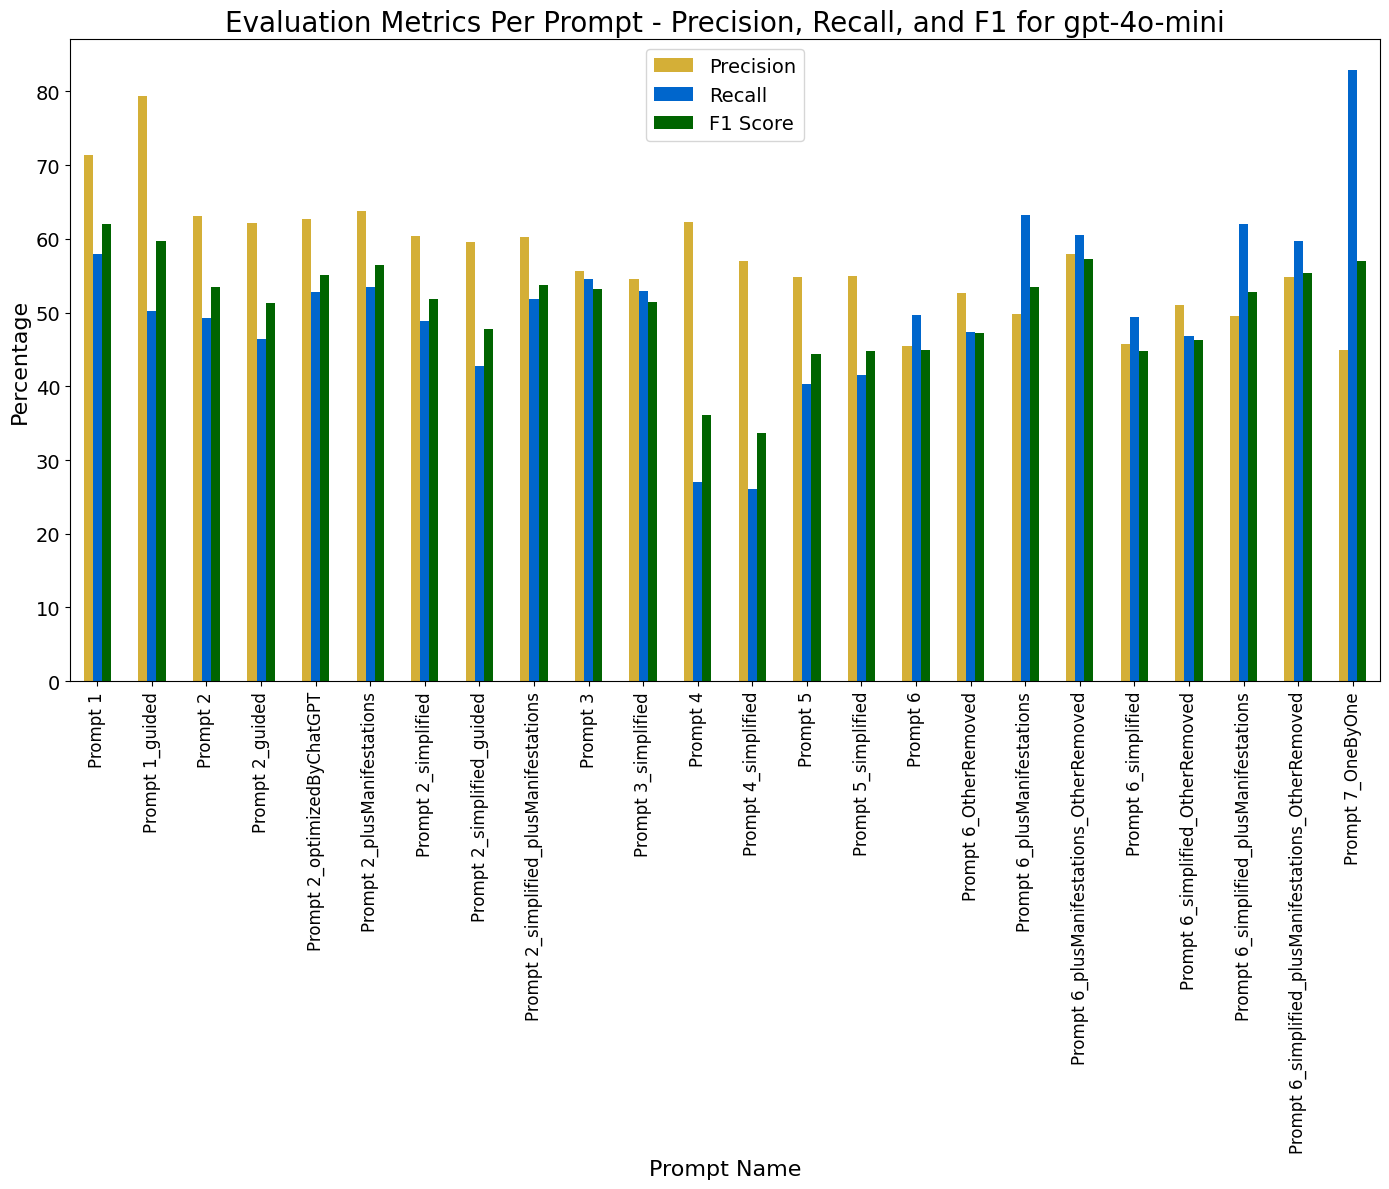

Model Name                                        Prompt Name  Precision  \
0   gpt-4o-mini                                           Prompt 1   0.713522   
1   gpt-4o-mini                                    Prompt 1_guided   0.793531   
2   gpt-4o-mini                                           Prompt 2   0.630611   
3   gpt-4o-mini                                    Prompt 2_guided   0.622077   
4   gpt-4o-mini                        Prompt 2_optimizedByChatGPT   0.626584   
5   gpt-4o-mini                        Prompt 2_plusManifestations   0.637463   
6   gpt-4o-mini                                Prompt 2_simplified   0.603695   
7   gpt-4o-mini                         Prompt 2_simplified_guided   0.595321   
8   gpt-4o-mini             Prompt 2_simplified_plusManifestations   0.602239   
9   gpt-4o-mini                                           Prompt 3   0.557014   
10  gpt-4o-mini                                Prompt 3_simplified   0.546021   
11  gpt-4o-mini                                           Prompt 4   0.623294   
12  gpt-4o-mini                                Prompt 4_simplified   0.569744   
13  gpt-4o-mini                                           Prompt 5   0.548802   
14  gpt-4o-mini                                Prompt 5_simplified   0.549084   
15  gpt-4o-mini                                           Prompt 6   0.454258   
16  gpt-4o-mini                              Prompt 6_OtherRemoved   0.526307   
17  gpt-4o-mini                        Prompt 6_plusManifestations   0.497846   
18  gpt-4o-mini           Prompt 6_plusManifestations_OtherRemoved   0.579911   
19  gpt-4o-mini                                Prompt 6_simplified   0.456684   
20  gpt-4o-mini                   Prompt 6_simplified_OtherRemoved   0.510760   
21  gpt-4o-mini             Prompt 6_simplified_plusManifestations   0.495267   
22  gpt-4o-mini  Prompt 6_simplified_plusManifestations_OtherRe...   0.547723   
23  gpt-4o-mini                                  Prompt 7_OneByOne   0.449867   

    SD Precision    Recall  SD Recall  F1 Score  SD F1 Score  \
0       0.206210  0.579633   0.174419  0.620612     0.173398   
1       0.197715  0.501745   0.193162  0.596544     0.186201   
2       0.209181  0.492918   0.176904  0.535283     0.167215   
3       0.202926  0.464189   0.187828  0.512558     0.178271   
4       0.210709  0.527573   0.187809  0.551467     0.176145   
5       0.208472  0.534956   0.181602  0.564950     0.169697   
6       0.211539  0.488993   0.189379  0.518884     0.181568   
7       0.208053  0.428047   0.205097  0.477261     0.189187   
8       0.204145  0.518599   0.186268  0.537403     0.171030   
9       0.196184  0.545848   0.188949  0.531458     0.175179   
10      0.206204  0.528557   0.205596  0.514359     0.184003   
11      0.204071  0.269992   0.148292  0.361261     0.148707   
12      0.242450  0.260666   0.159681  0.336578     0.158036   
13      0.211922  0.403198   0.186649  0.443503     0.180240   
14      0.190355  0.414682   0.189334  0.447960     0.167868   
15      0.208082  0.496219   0.247513  0.448920     0.211699   
16      0.225334  0.473315   0.252742  0.472215     0.225177   
17      0.187253  0.632015   0.207527  0.534285     0.181389   
18      0.200028  0.604982   0.217944  0.572280     0.192205   
19      0.205681  0.494038   0.250019  0.447769     0.207806   
20      0.224782  0.468010   0.252670  0.462757     0.219221   
21      0.190576  0.620433   0.210815  0.527874     0.181375   
22      0.196621  0.596866   0.217595  0.553281     0.188038   
23      0.150824  0.829095   0.103844  0.569765     0.146158   

    Number_of_conditions_analyzed  Average Percentage of Matched Terms  \
0                             100                            89.081632   
1                             100                            91.534598   
2                             100                            87.608700   
3                             100                            87.223201   
4       

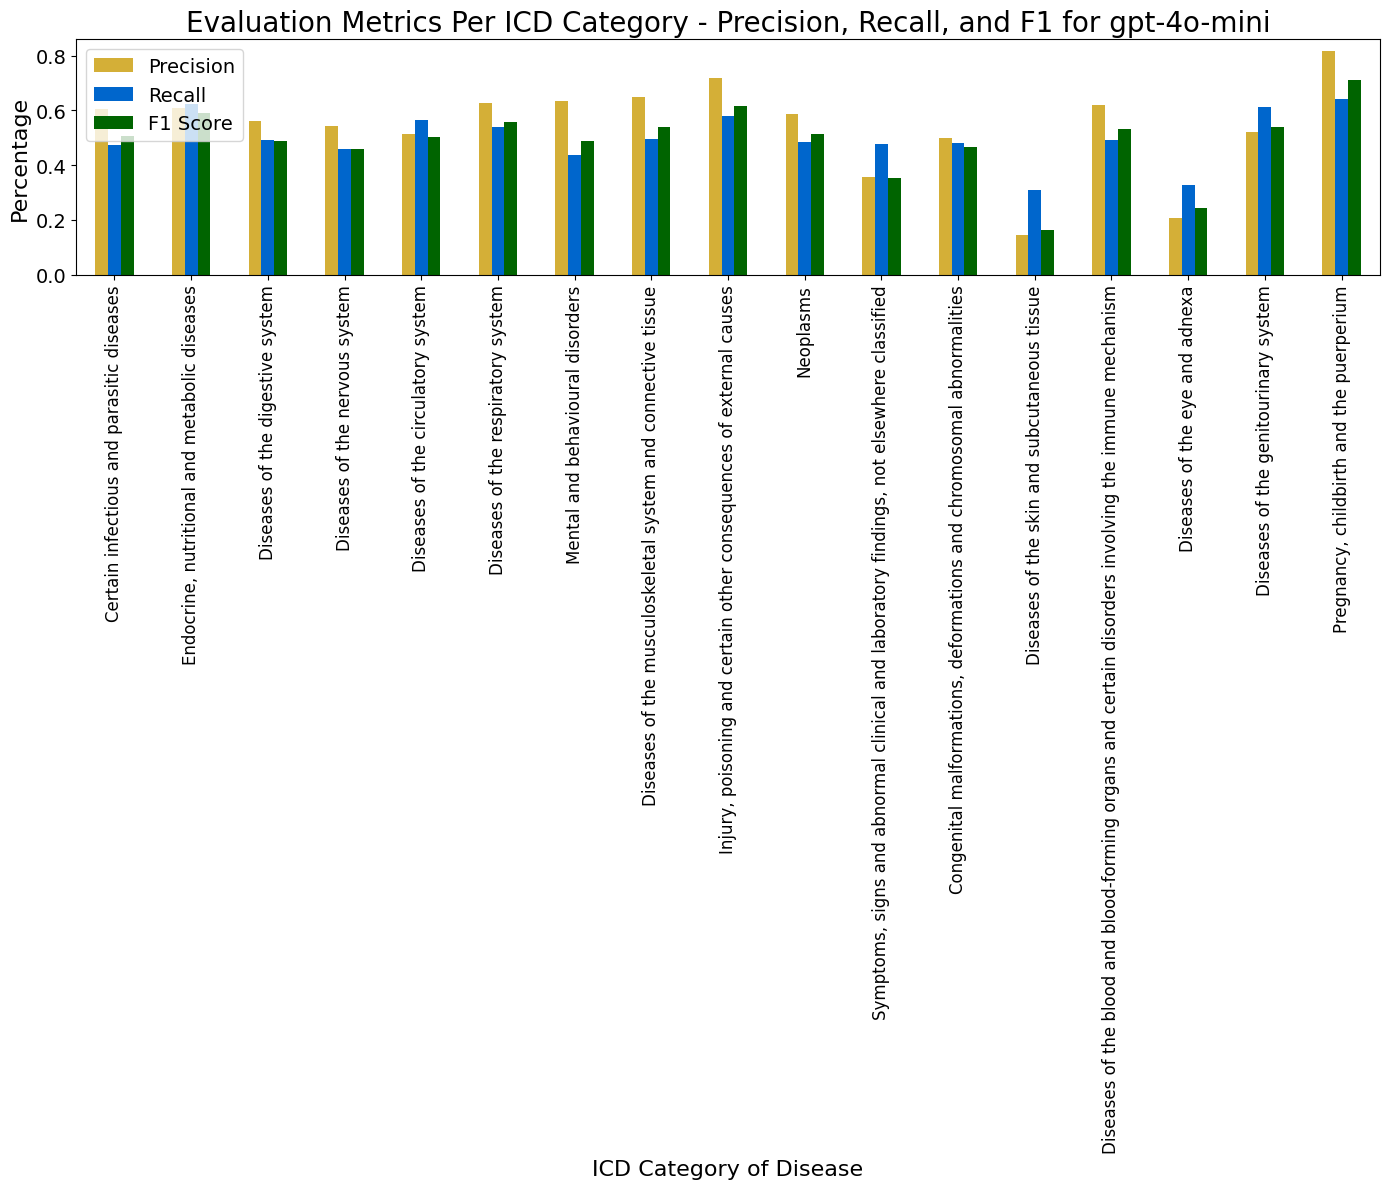

Class Range                            ICD Category of Disease    TP    FP  \
0      A00-B99          Certain infectious and parasitic diseases  7614  5106   
1      E00-E90      Endocrine, nutritional and metabolic diseases  7953  5328   
2      K00-K93                   Diseases of the digestive system  3708  3289   
3      G00-G99                     Diseases of the nervous system  3188  2890   
4      I00-I99                 Diseases of the circulatory system  2755  3047   
5      J00-J99                 Diseases of the respiratory system  2519  1770   
6      F00-F99                   Mental and behavioural disorders  3543  1788   
7      M00-M99  Diseases of the musculoskeletal system and con...  1988  1263   
8      S00-T98  Injury, poisoning and certain other consequenc...  2598  1104   
9      C00-D48                                          Neoplasms  2067  1562   
10     R00-R99  Symptoms, signs and abnormal clinical and labo...  1163  2727   
11     Q00-Q99  Congenital malformations, deformations and chr...  1079  1235   
12     L00-L99       Diseases of the skin and subcutaneous tissue   213  1440   
13     D50-D89  Diseases of the blood and blood-forming organs...   967   574   
14     H00-H59                     Diseases of the eye and adnexa   134   561   
15     N00-N99               Diseases of the genitourinary system   396   390   
16    O00-O099           Pregnancy, childbirth and the puerperium   617   146   

      FN  Precision  SD Precision    Recall  SD Recall  F1 Score  SD F1 Score  \
0   8994   0.604461      0.174681  0.471762   0.206135  0.507428     0.166609   
1   4623   0.608177      0.221020  0.622874   0.242369  0.590727     0.210794   
2   4068   0.560824      0.197507  0.491575   0.198929  0.488637     0.141578   
3   3916   0.542901      0.189327  0.458610   0.188515  0.459856     0.139501   
4   2549   0.512572      0.188869  0.564846   0.270445  0.502721     0.189645   
5   2113   0.627646      0.190351  0.538955   0.156547  0.558380     0.139596   
6   4233   0.635348      0.211010  0.435906   0.245633  0.489771     0.223836   
7   2332   0.650213      0.220447  0.494091   0.253710  0.538016     0.217993   
8   2010   0.717542      0.154498  0.579032   0.238601  0.615376     0.186993   
9   2301   0.588010      0.164666  0.483501   0.209422  0.513524     0.169398   
10  1381   0.356502      0.240391  0.478999   0.207784  0.352821     0.162123   
11  1201   0.497869      0.178142  0.481964   0.187683  0.465655     0.153191   
12   411   0.145947      0.160570  0.309028   0.244144  0.162245     0.162417   
13  1001   0.618488      0.222822  0.491362   0.236793  0.532500     0.216761   
14   274   0.204973      0.136568  0.328431   0.201481  0.242793     0.142686   
15   252   0.519719      0.140918  0.611111   0.222222  0.540299     0.143984   
16   343   0.818672      0.065305  0.642708   0.116208  0.710690     0.075408   

    YES Count  NO Count  Percentage of Matched Terms  \
0       10232      2488                    80.440252   
1       10835      2446                    81.582712   
2        5552      1445                    79.348292   
3        4694      1384                    77.229352   
4        4542      1260                    78.283351   
5        3356       933                    78.246678   
6        4676       655                    87.713375   
7        2643       608                    81.298062   
8        2930       772                    79.146407   
9        2970       659                    81.840727   
10       3163       727                    81.311054   
11       1902       412                    82.195333   
12       1160       493                    70.175439   
13       1253       288                    81.310837   
14        569       126                    81.870504   
15        635       151                    80.788804   
16        692        71                    90.694626   

    Percentage_of_conditions_analyzed Precision formatted Recall formatted  

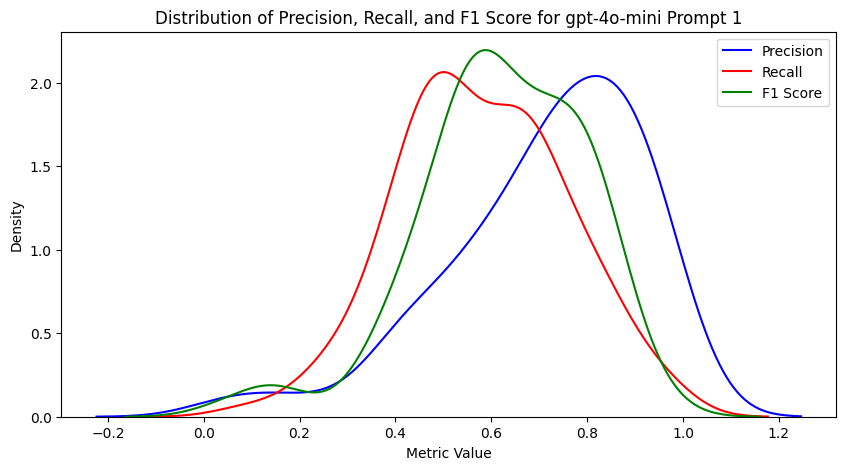

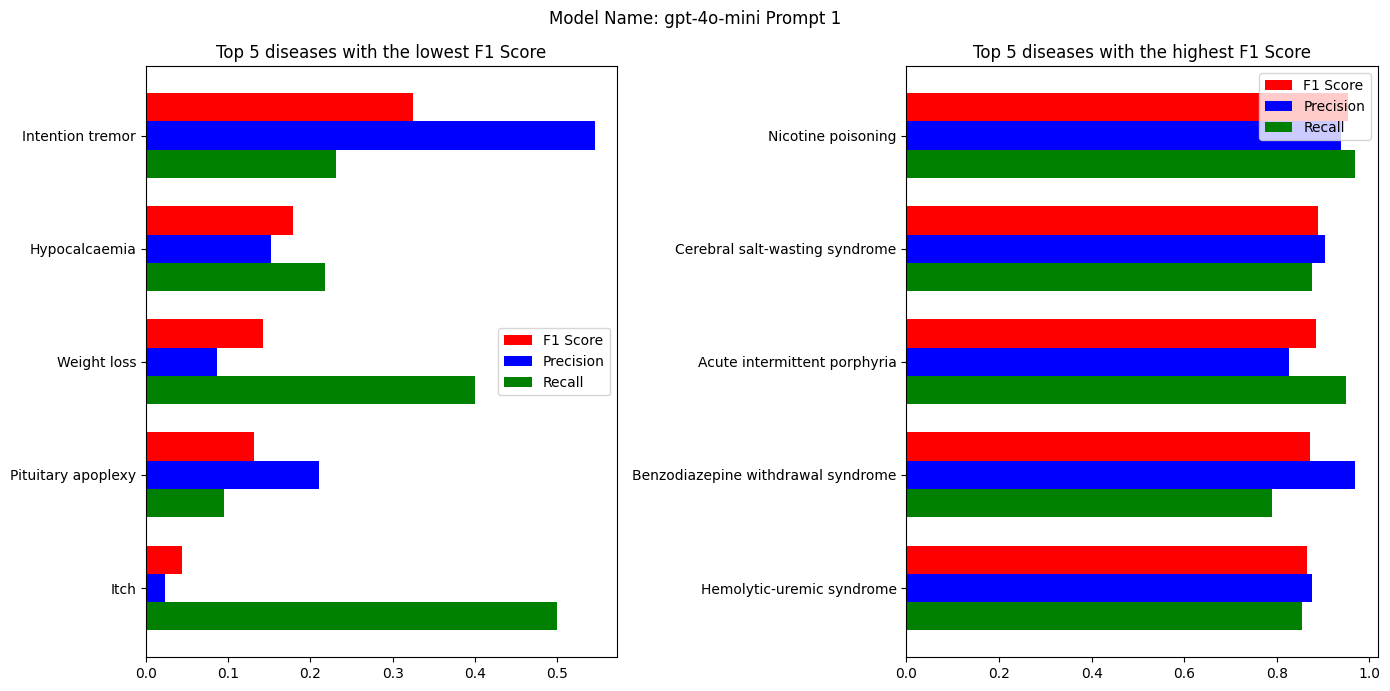

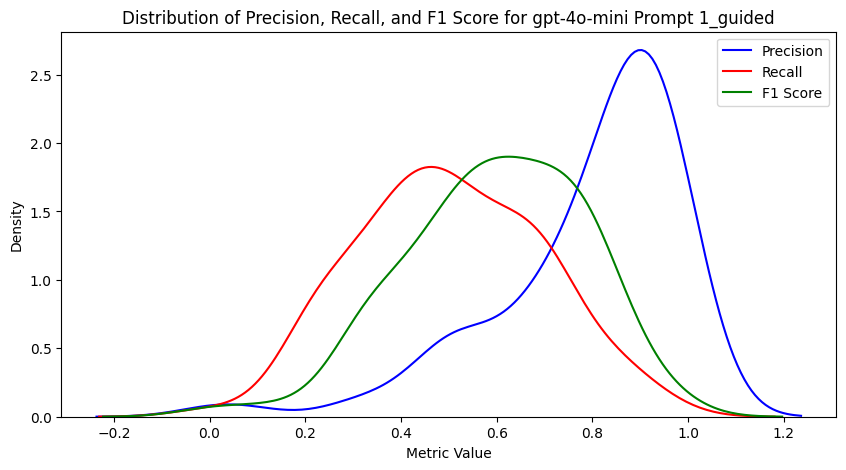

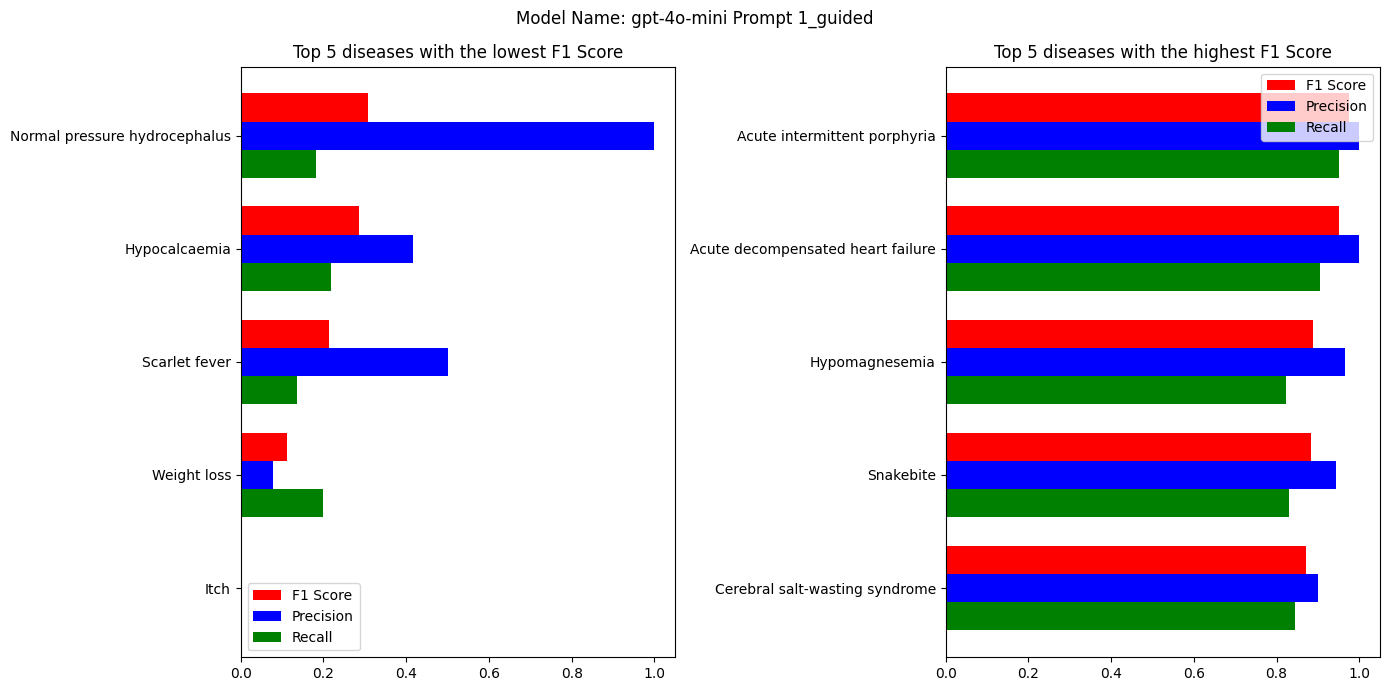

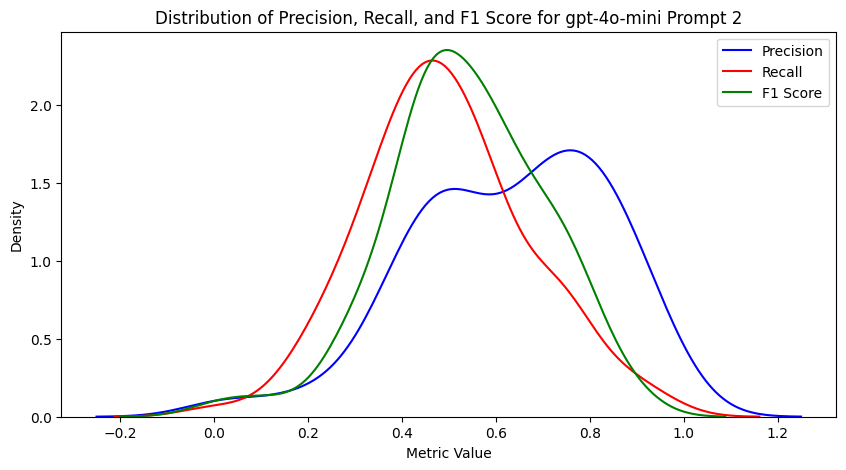

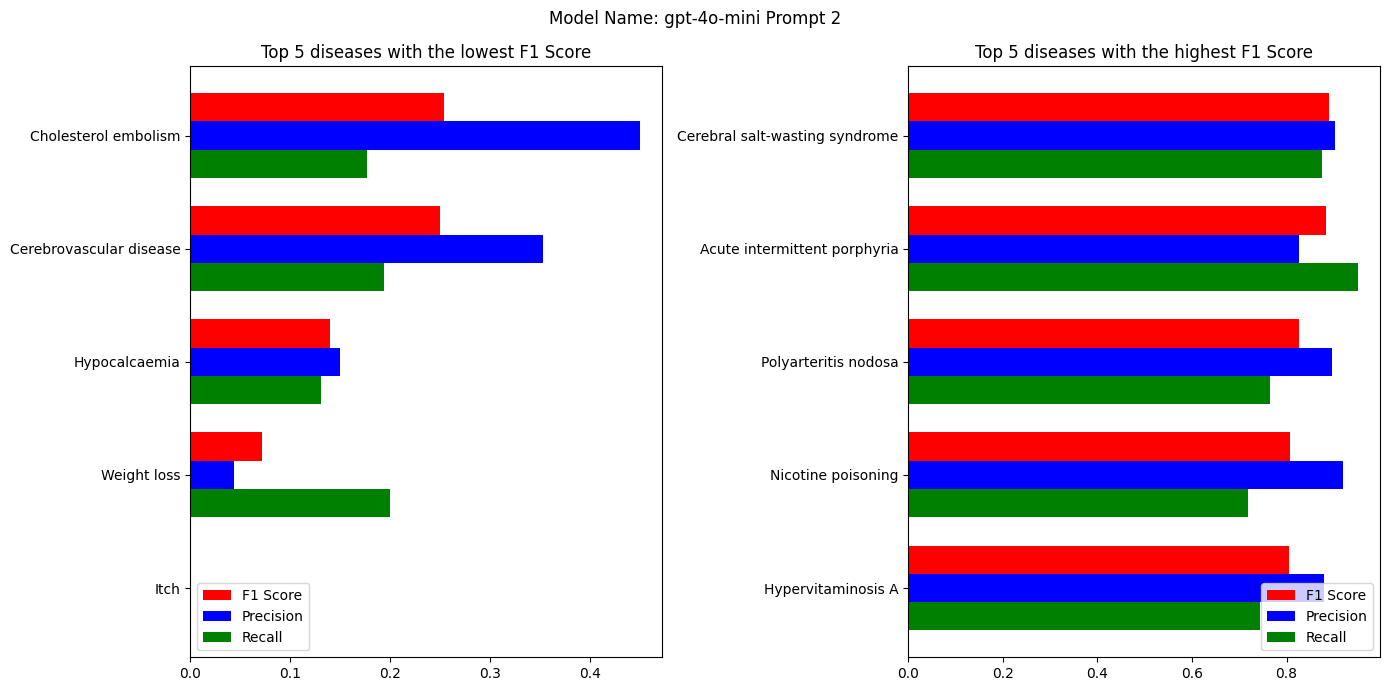

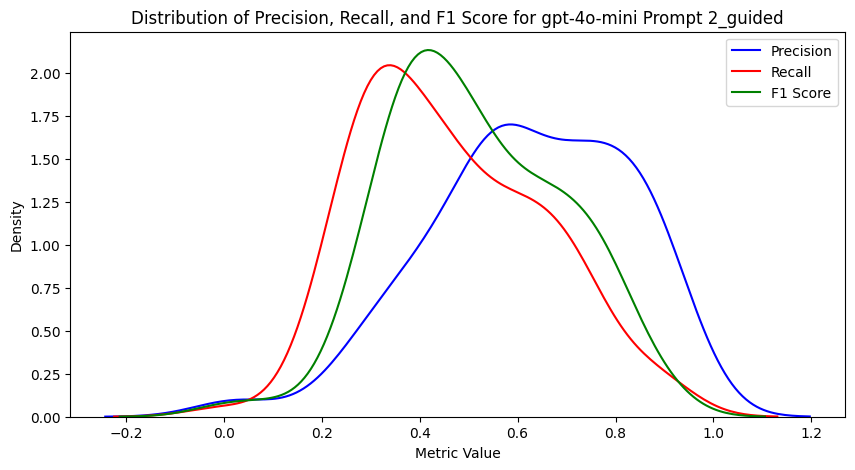

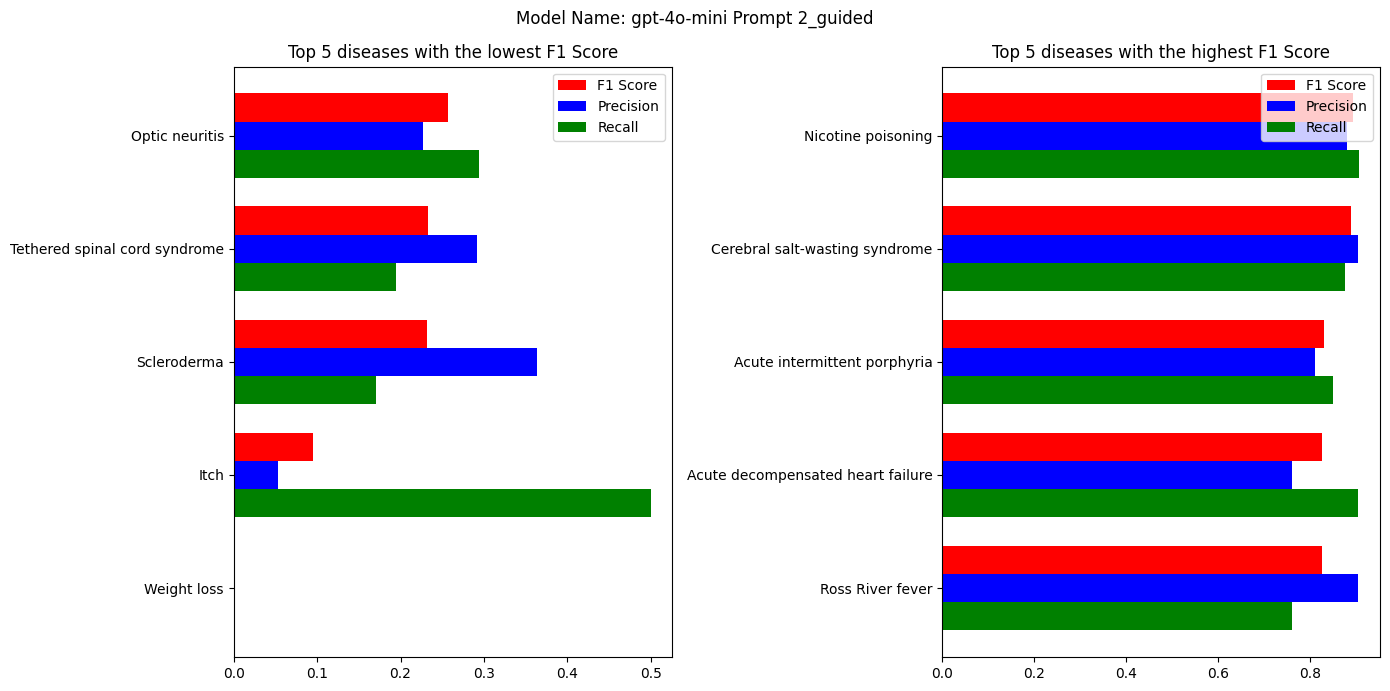

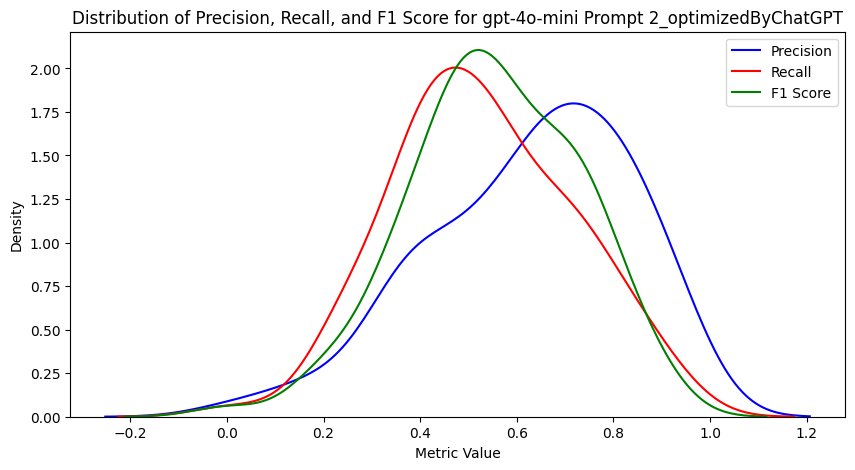

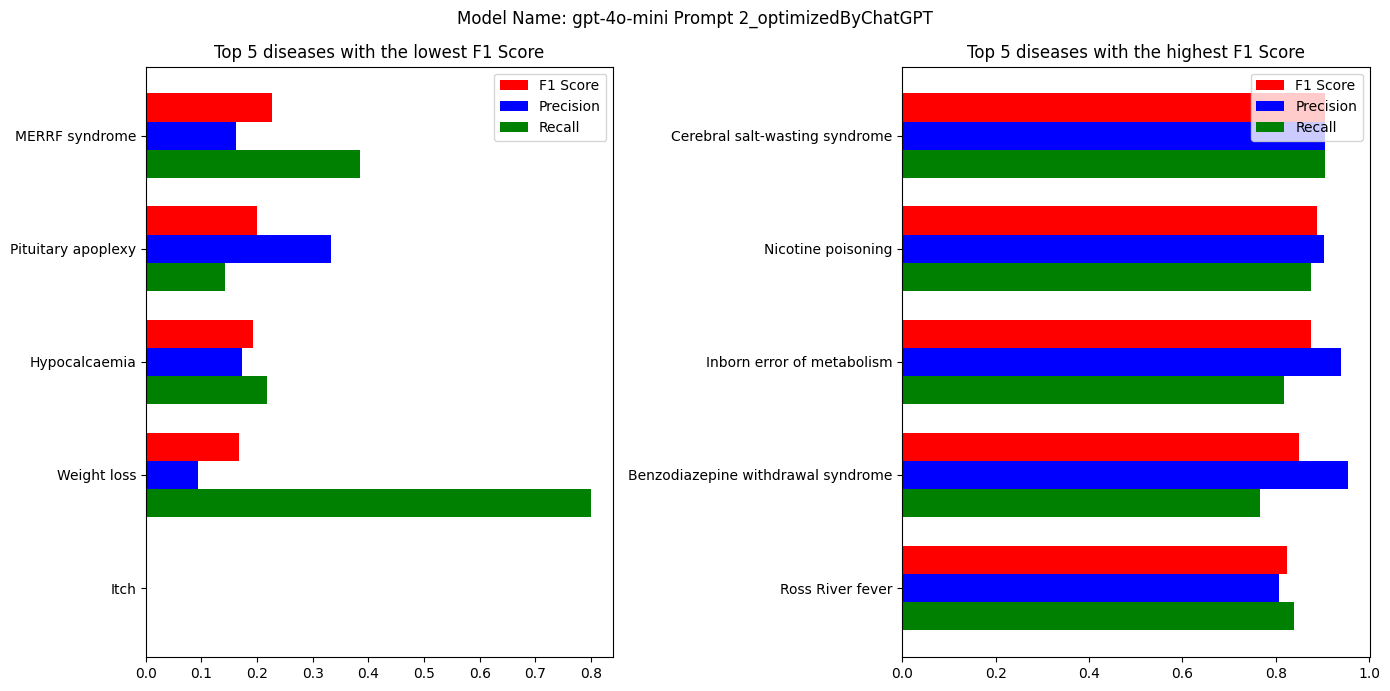

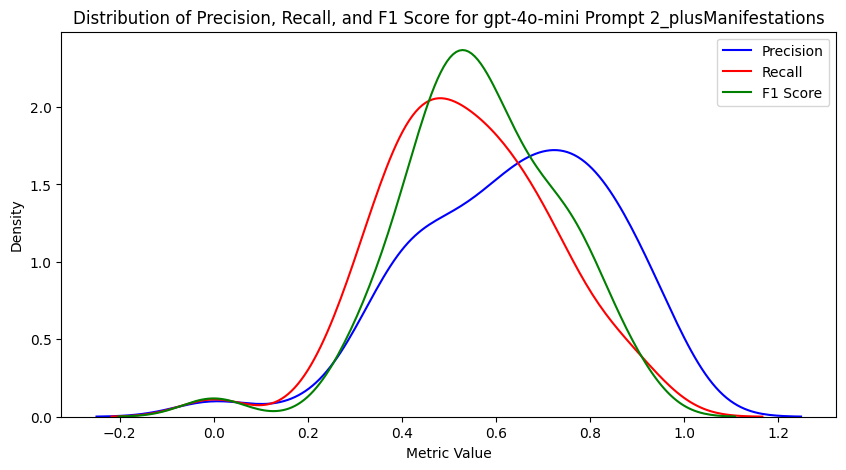

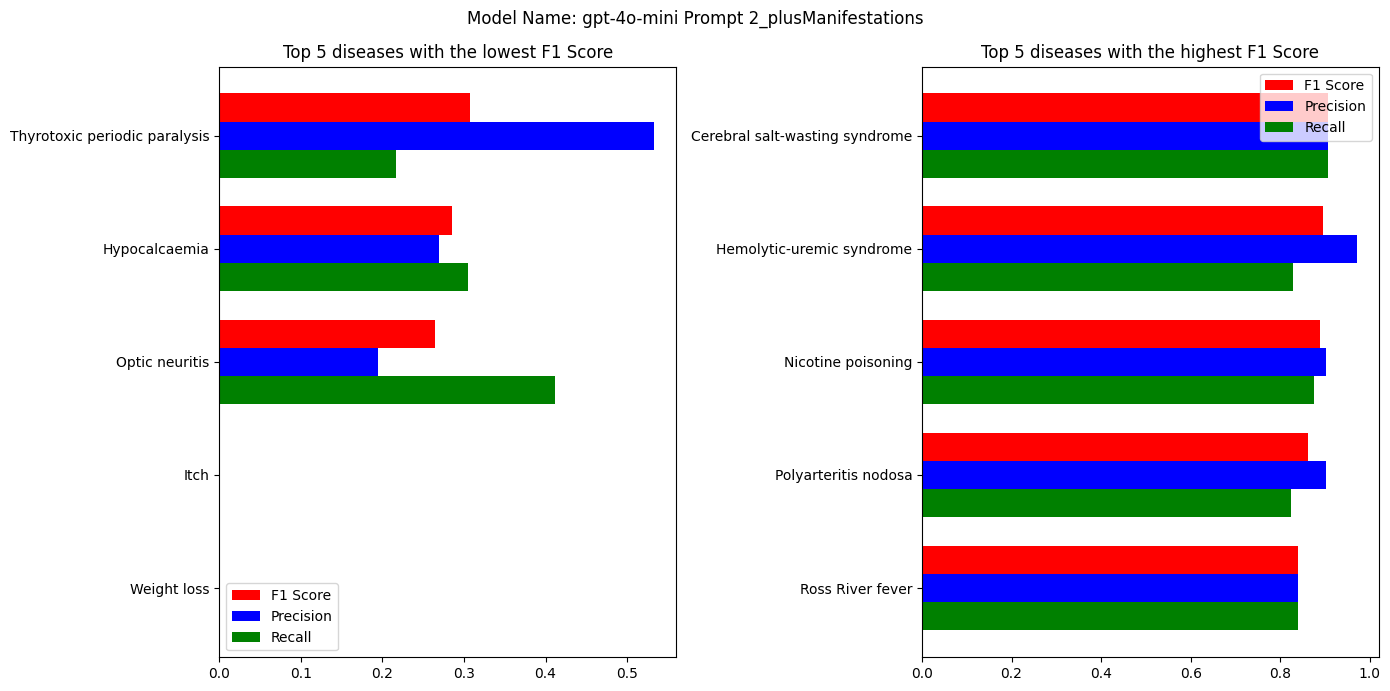

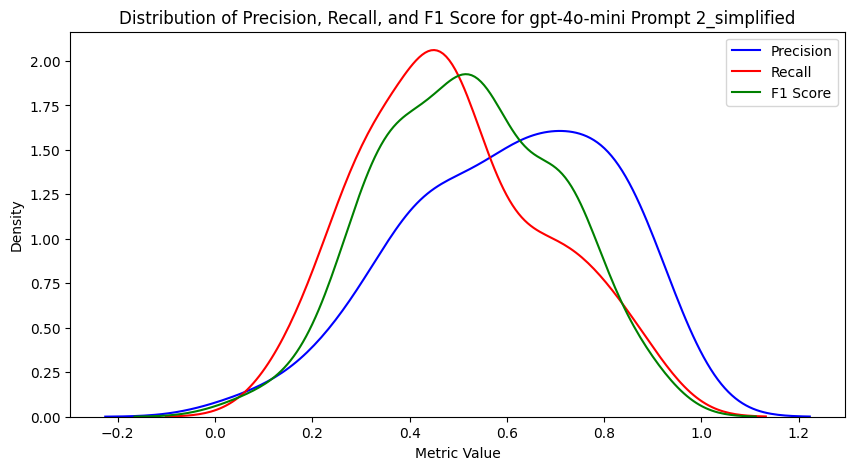

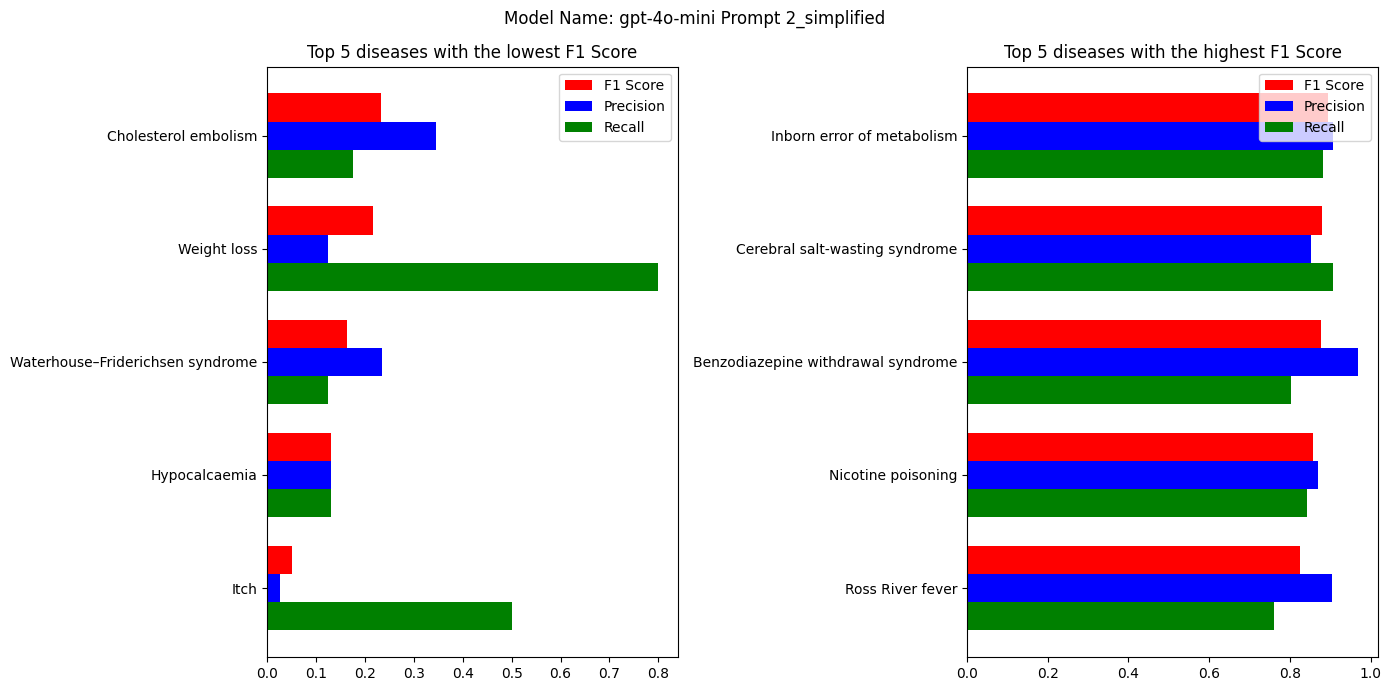

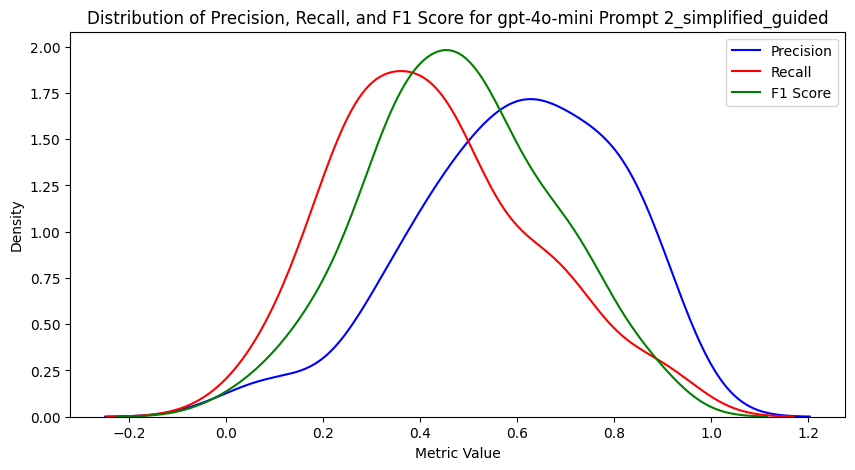

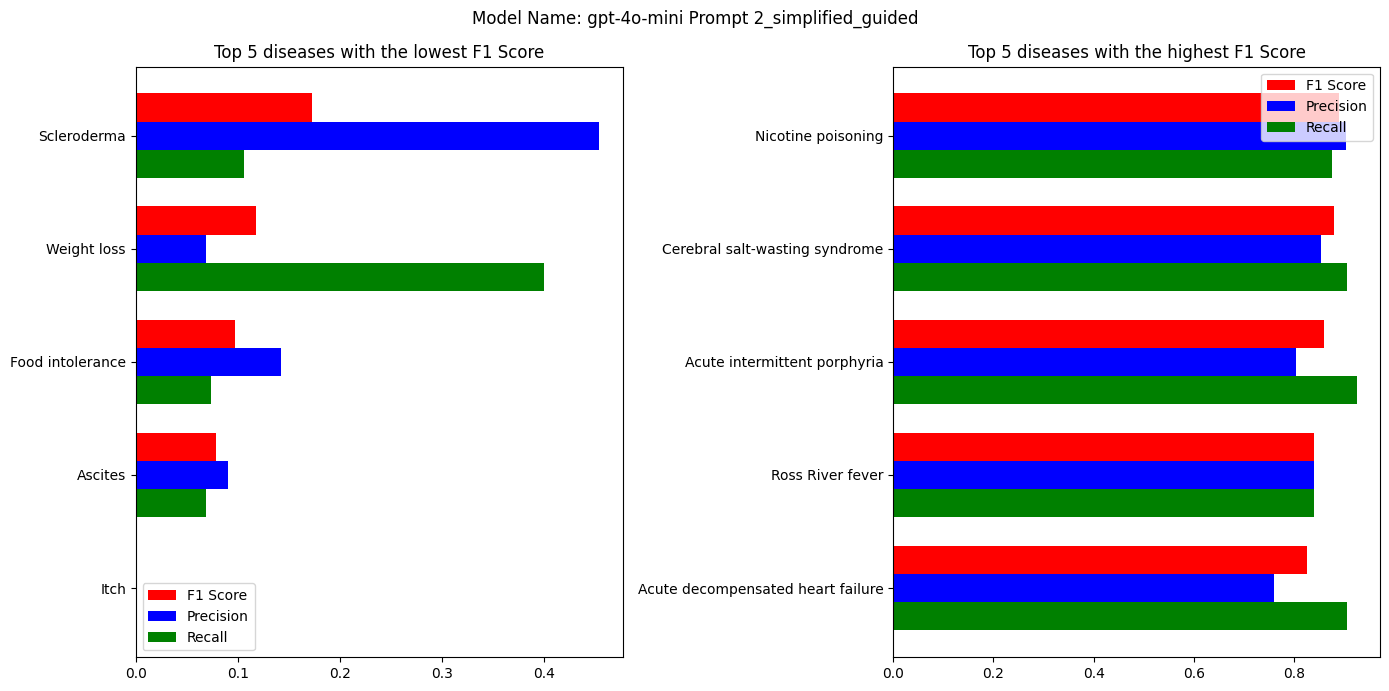

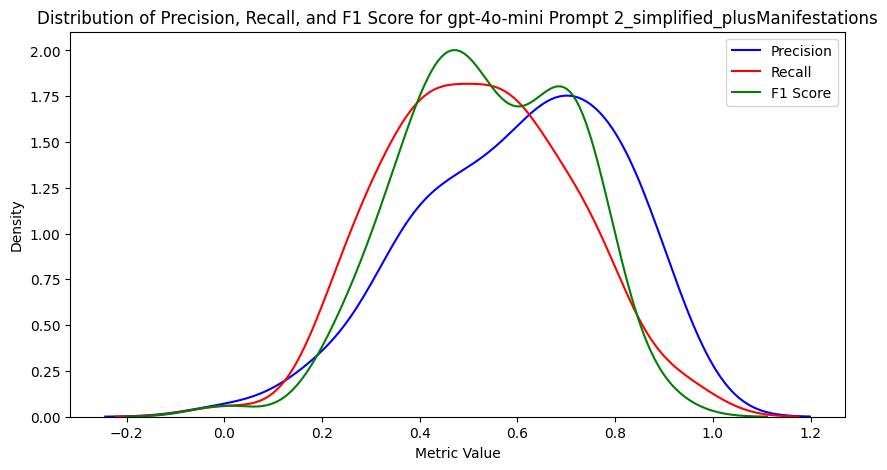

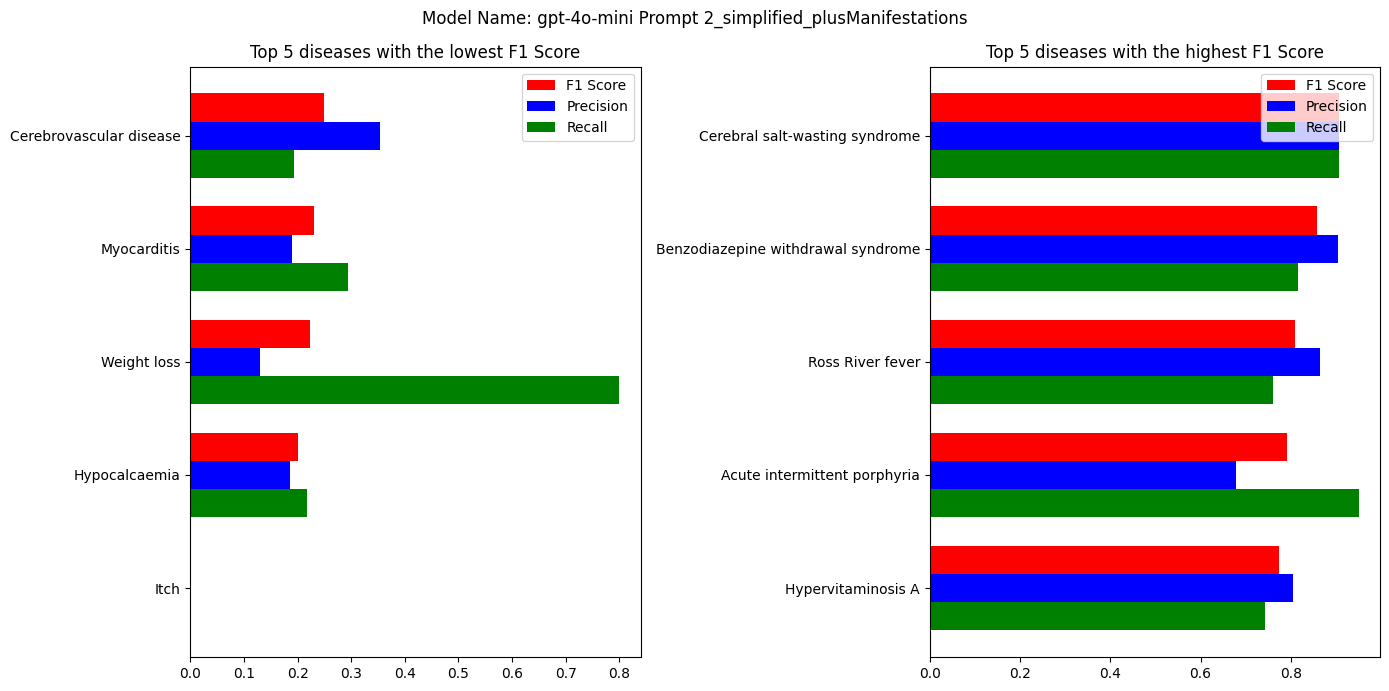

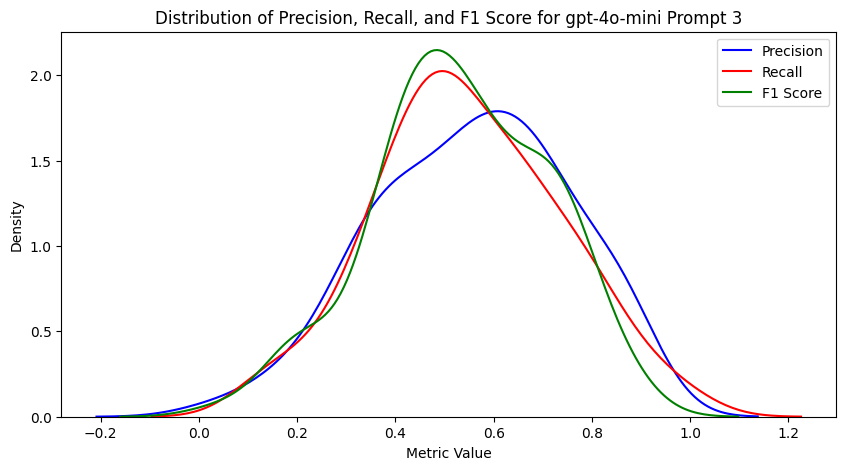

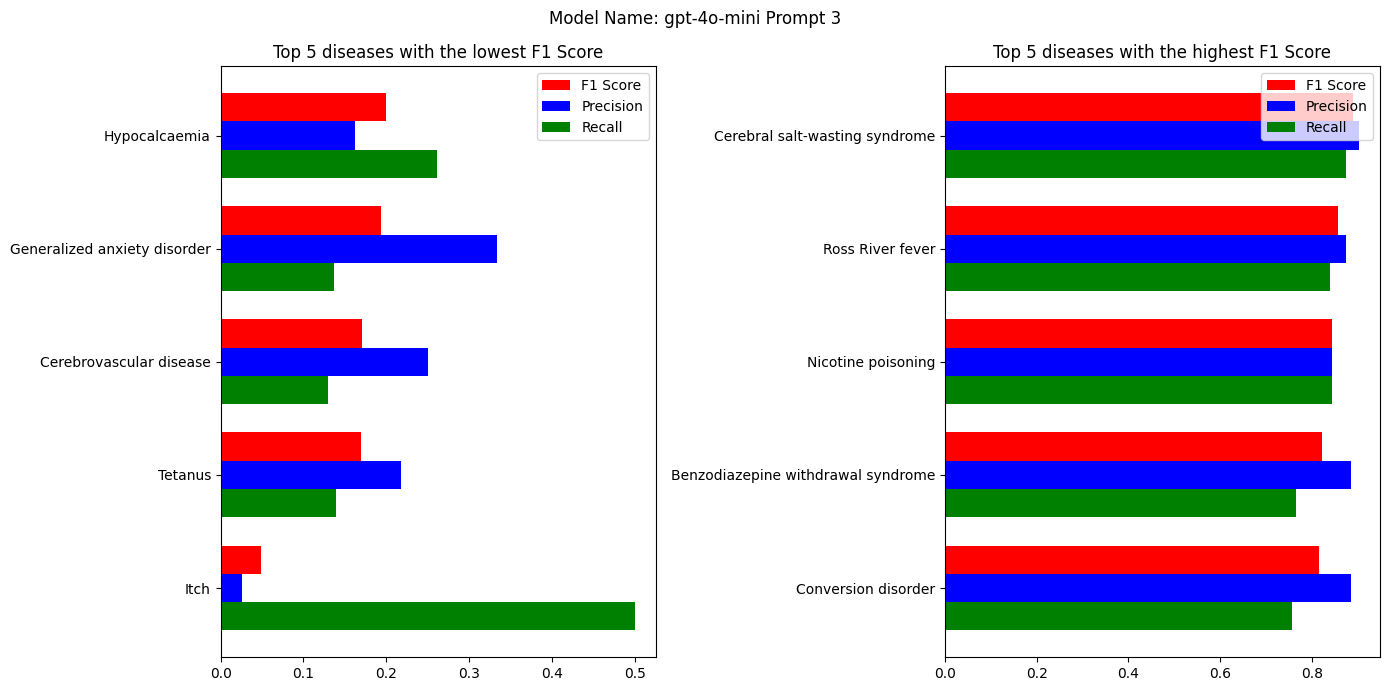

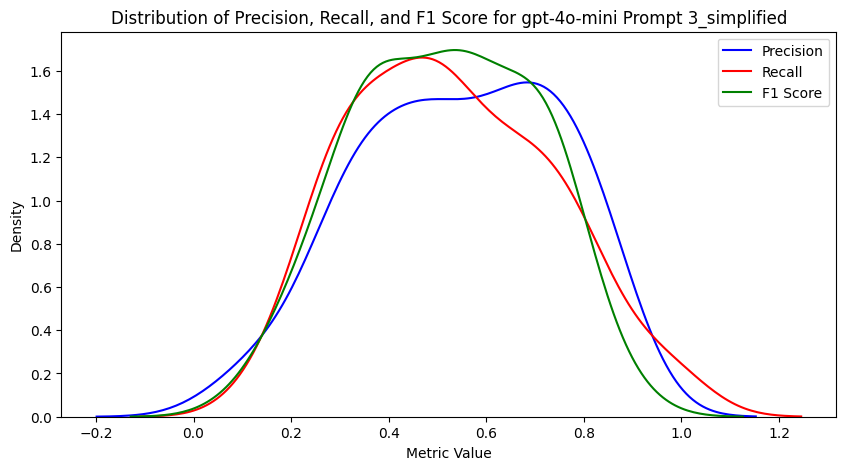

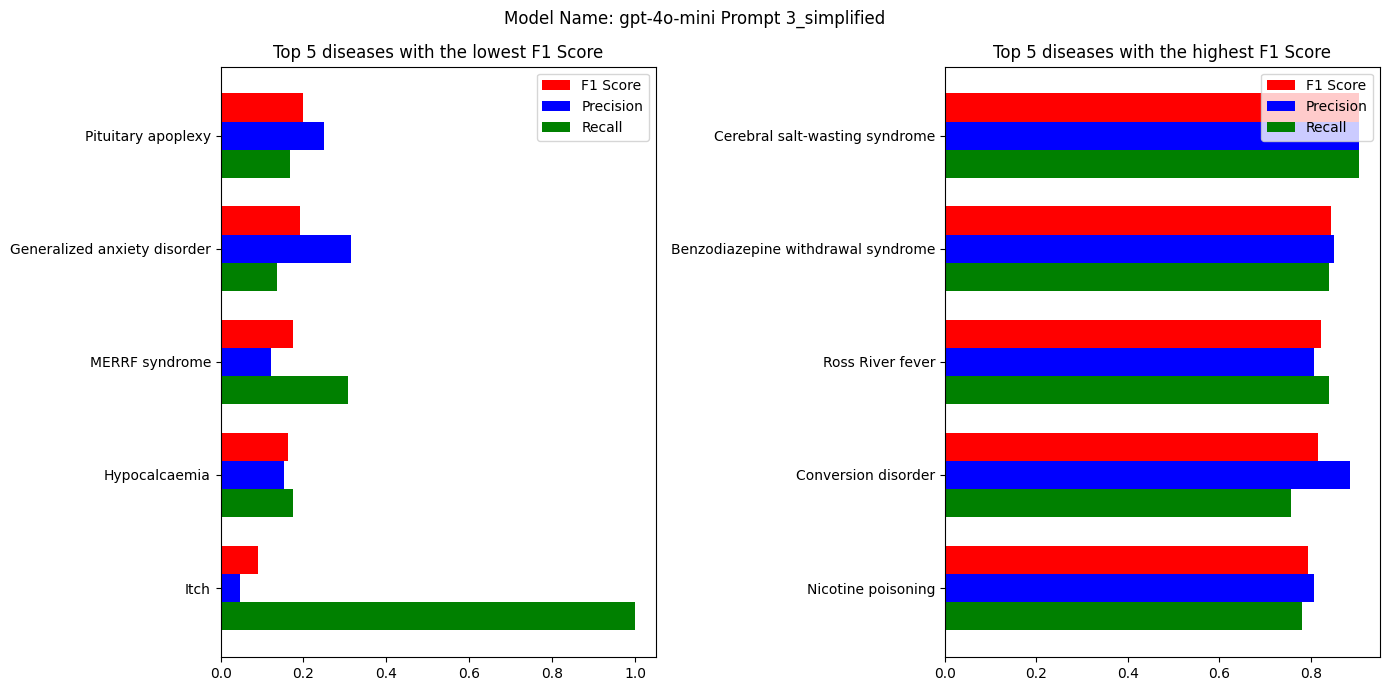

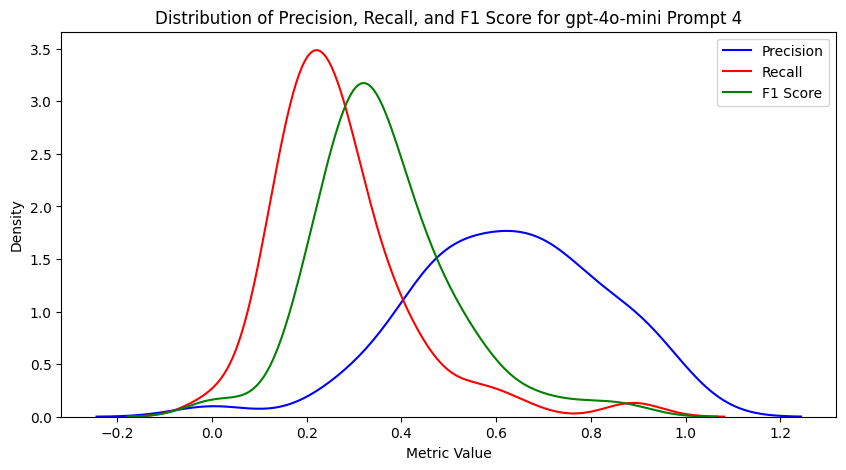

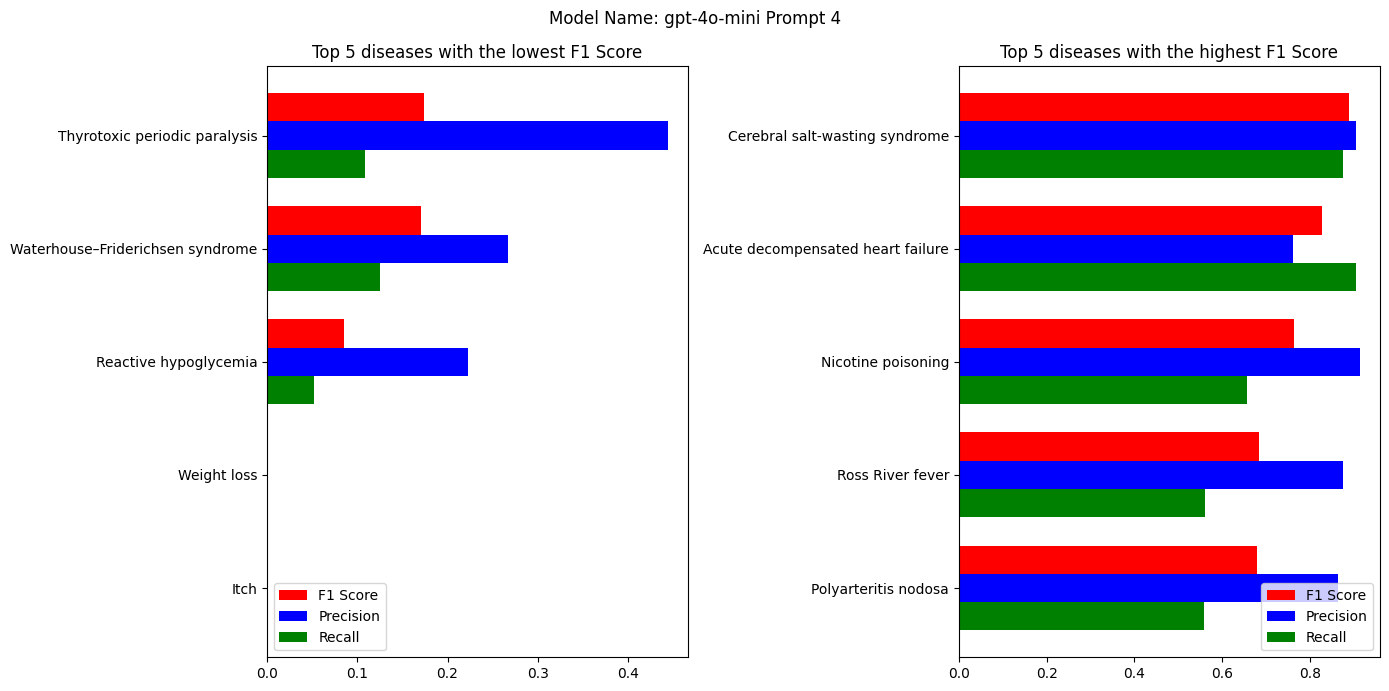

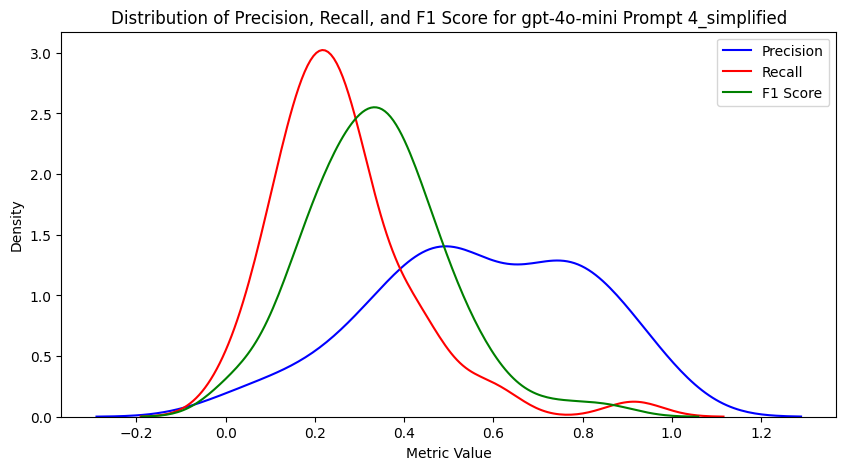

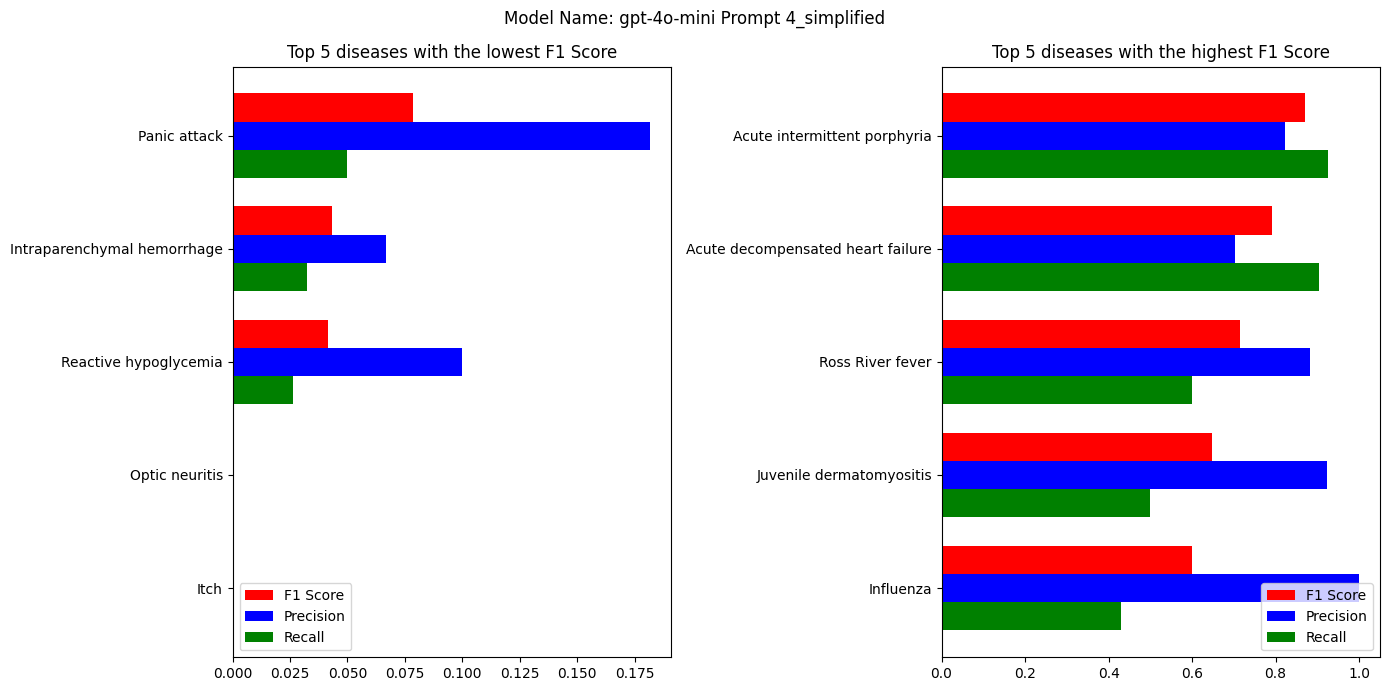

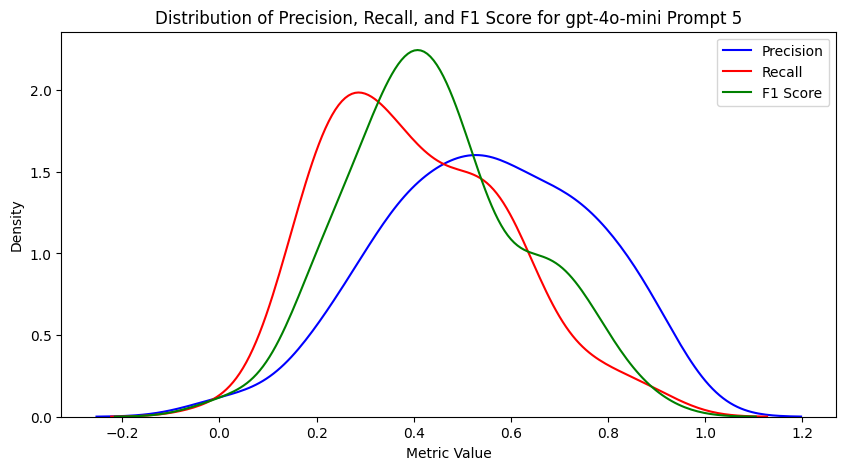

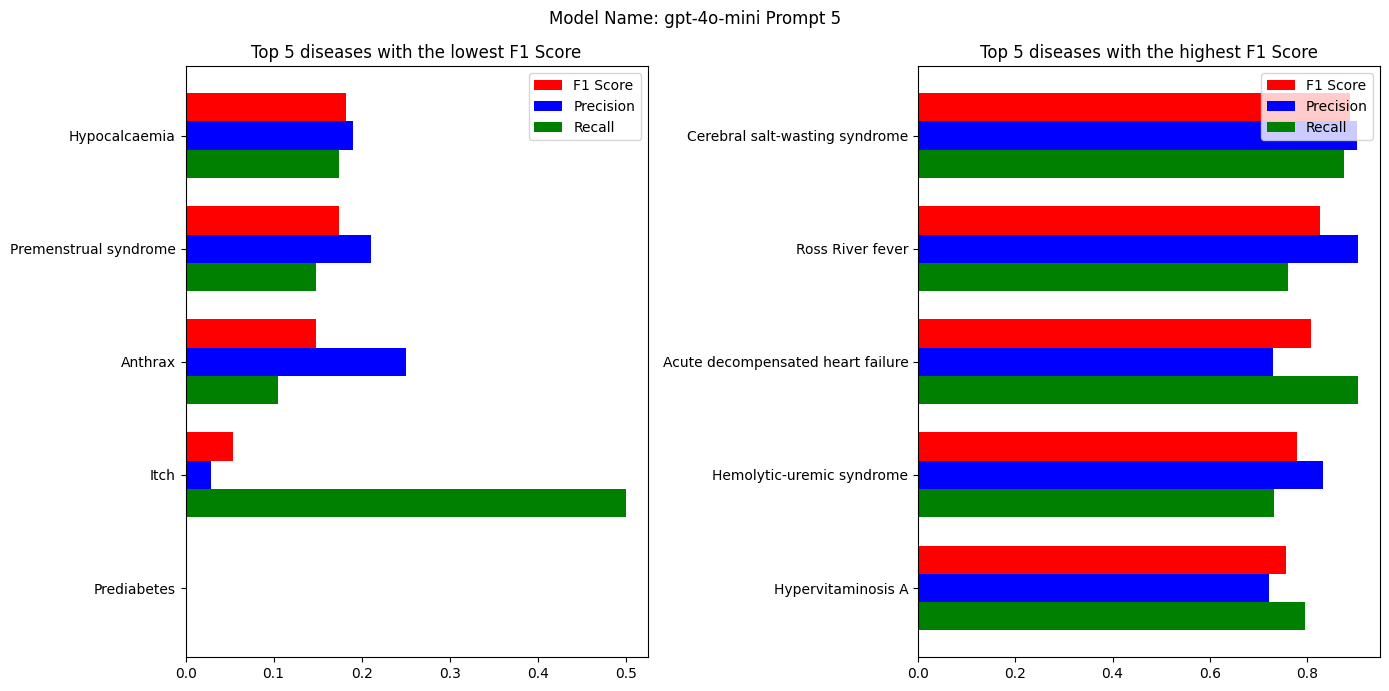

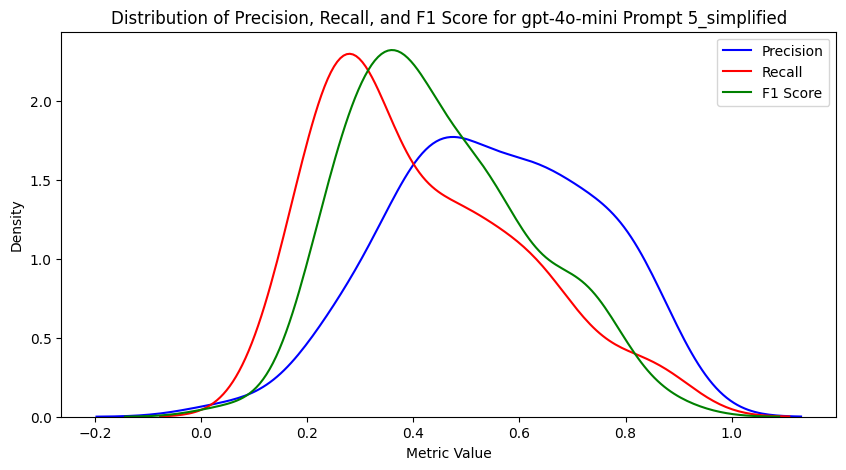

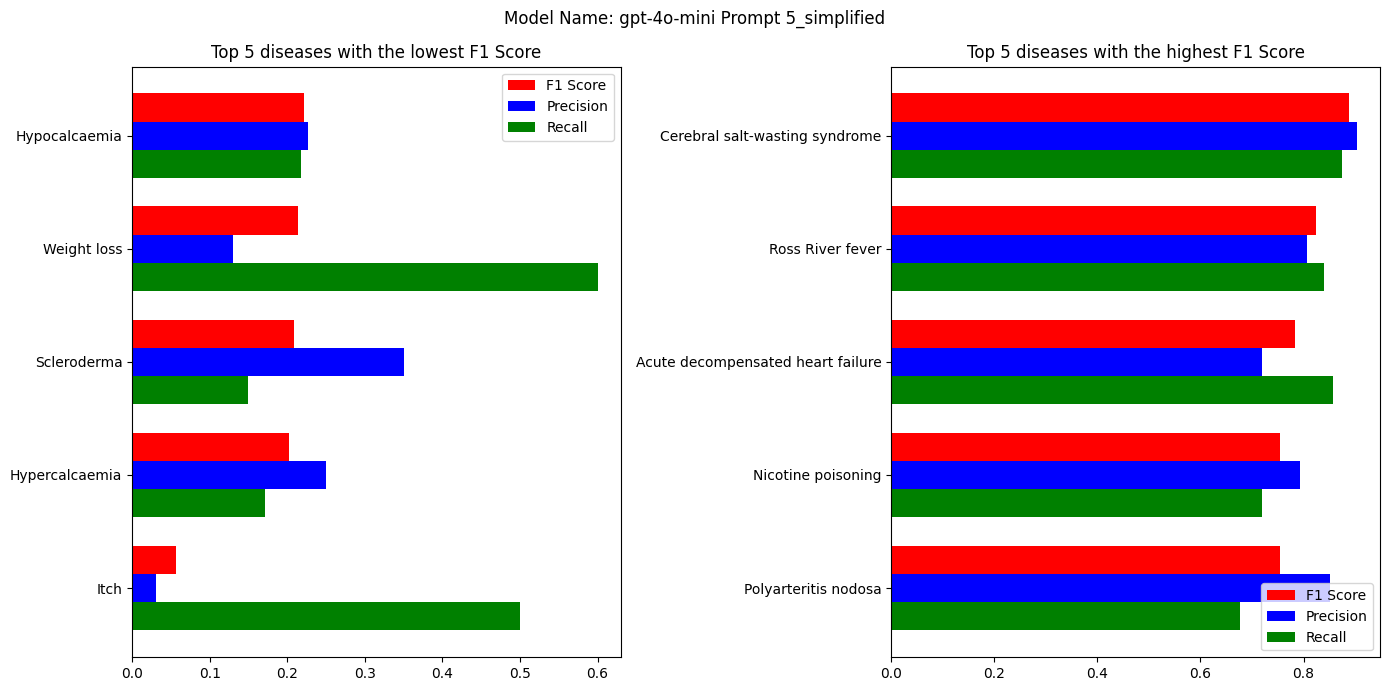

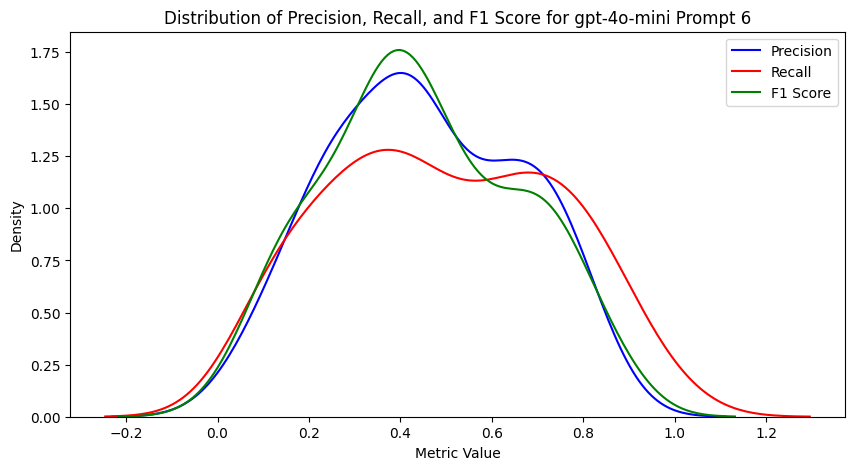

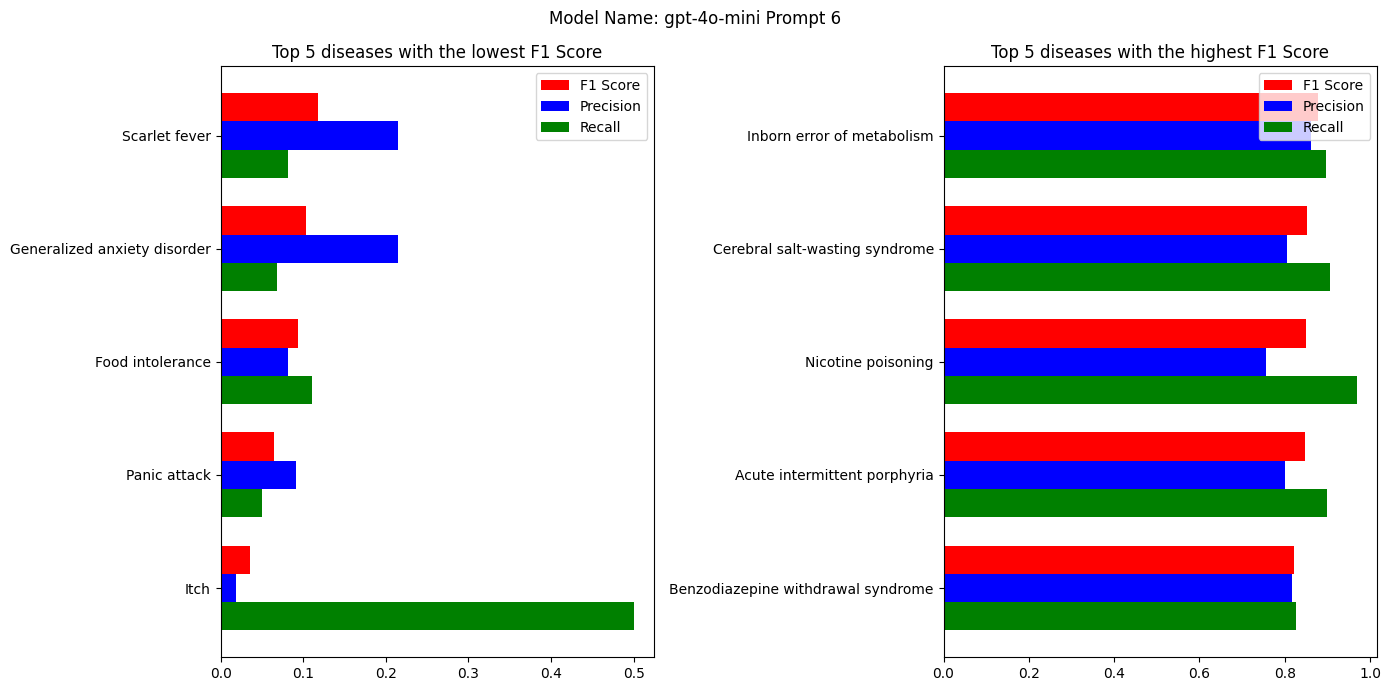

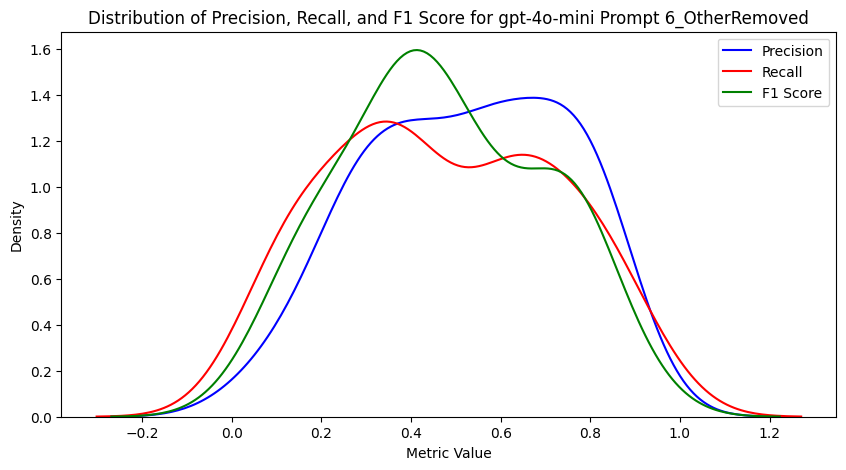

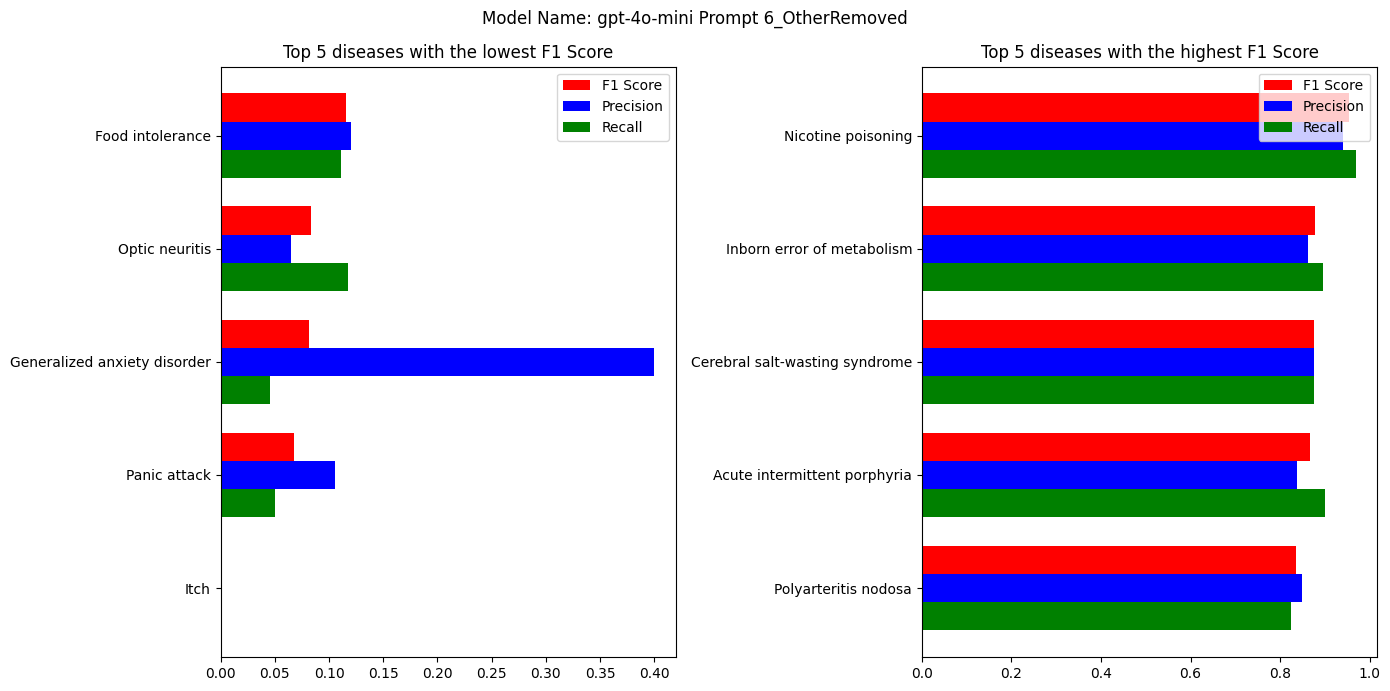

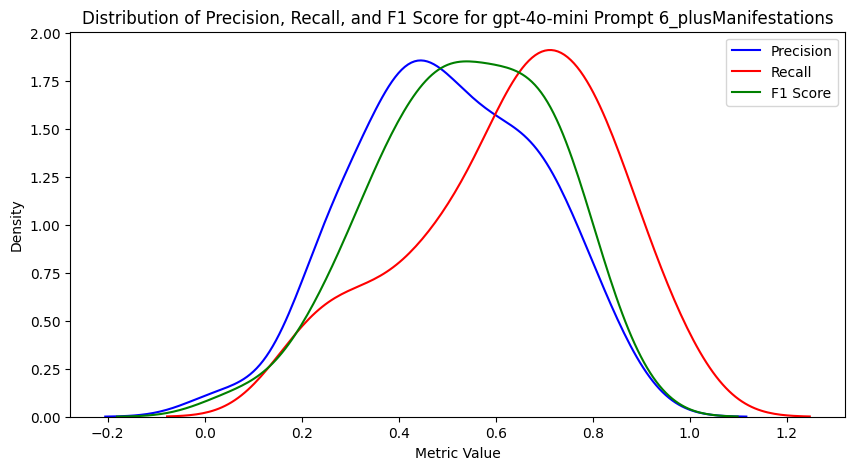

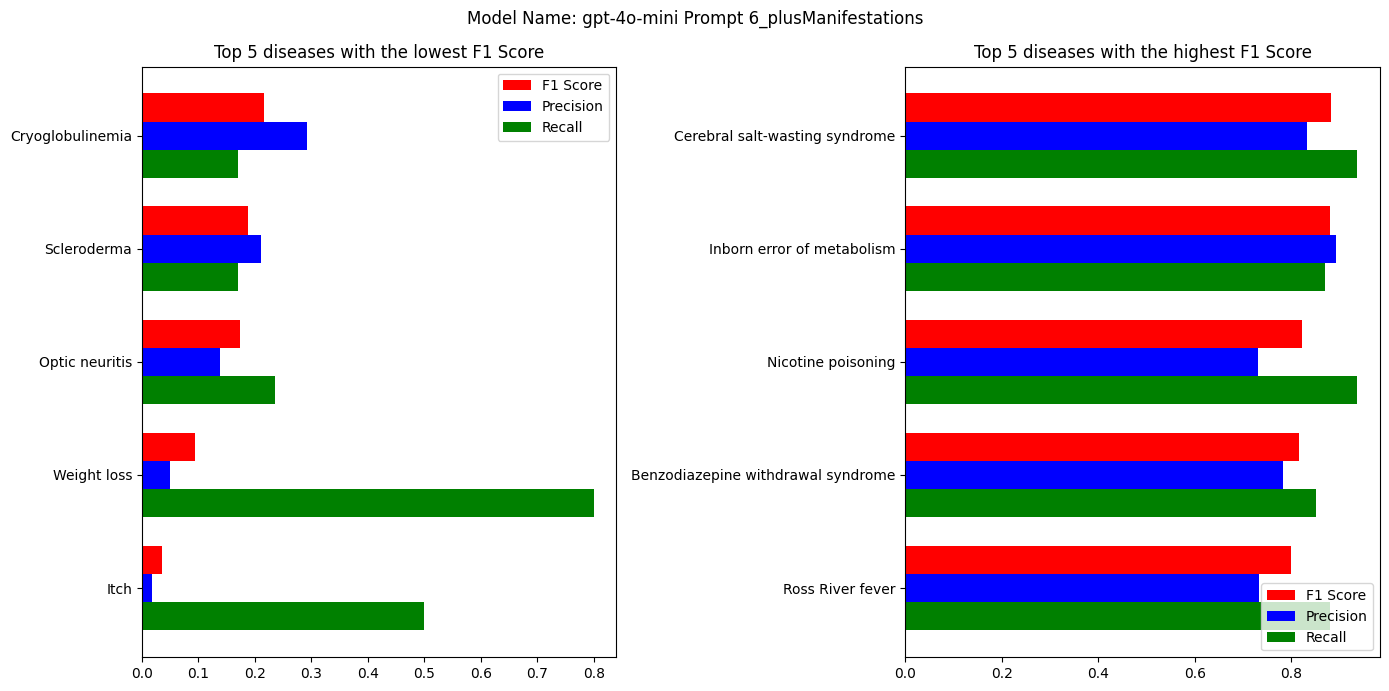

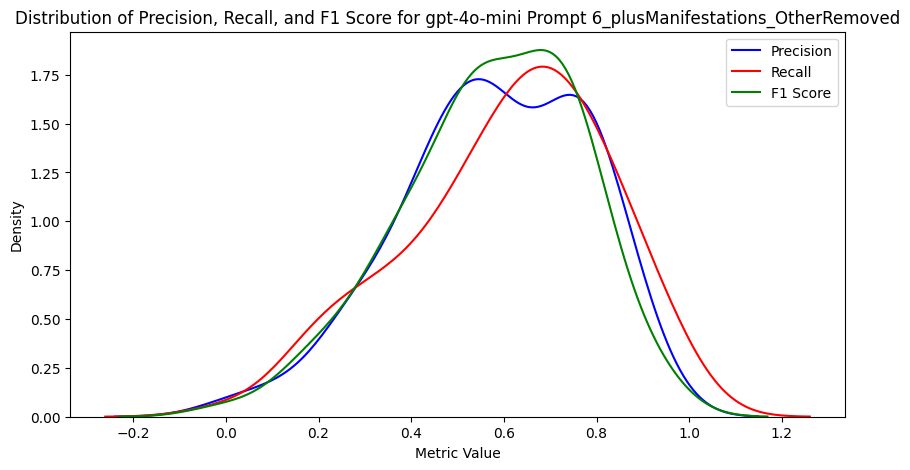

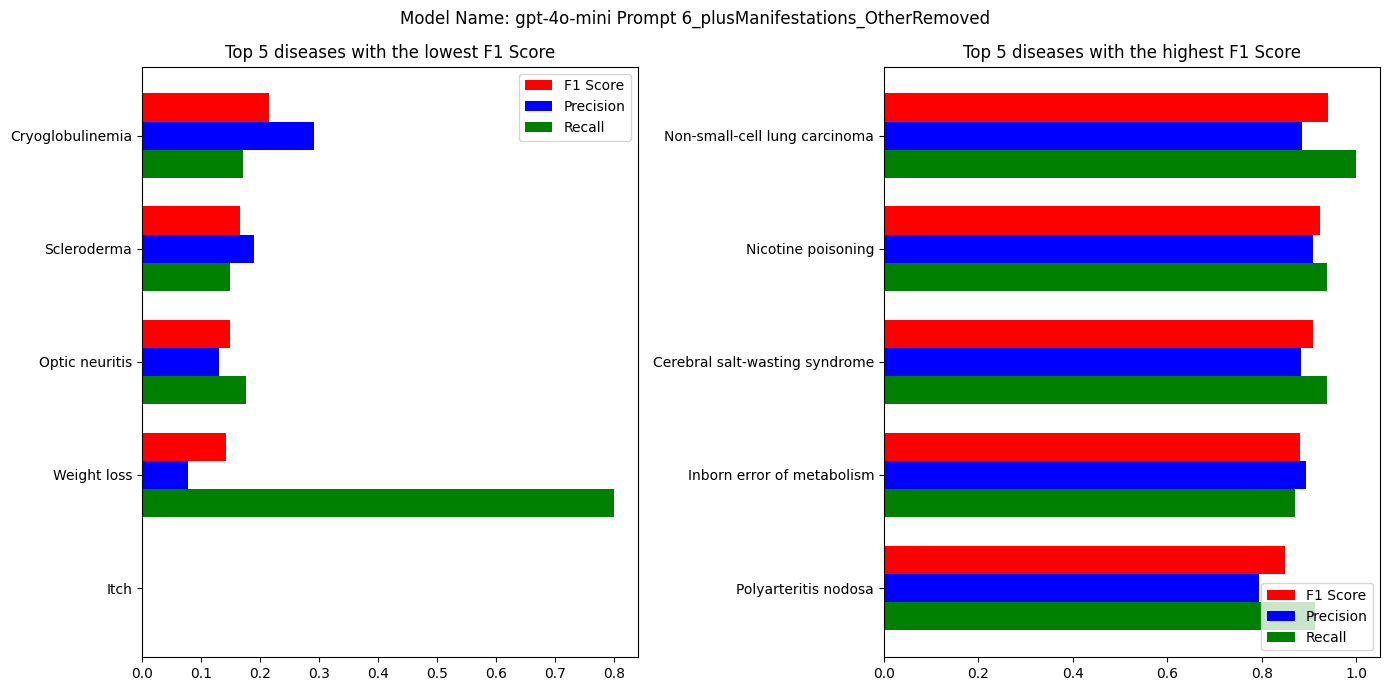

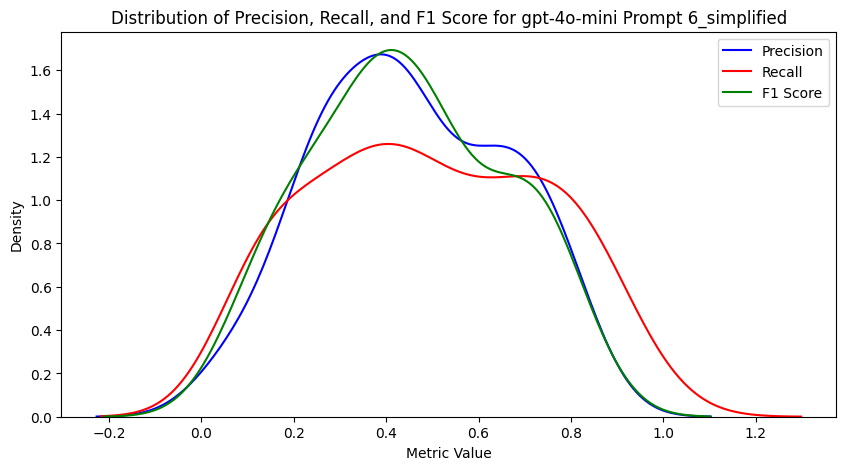

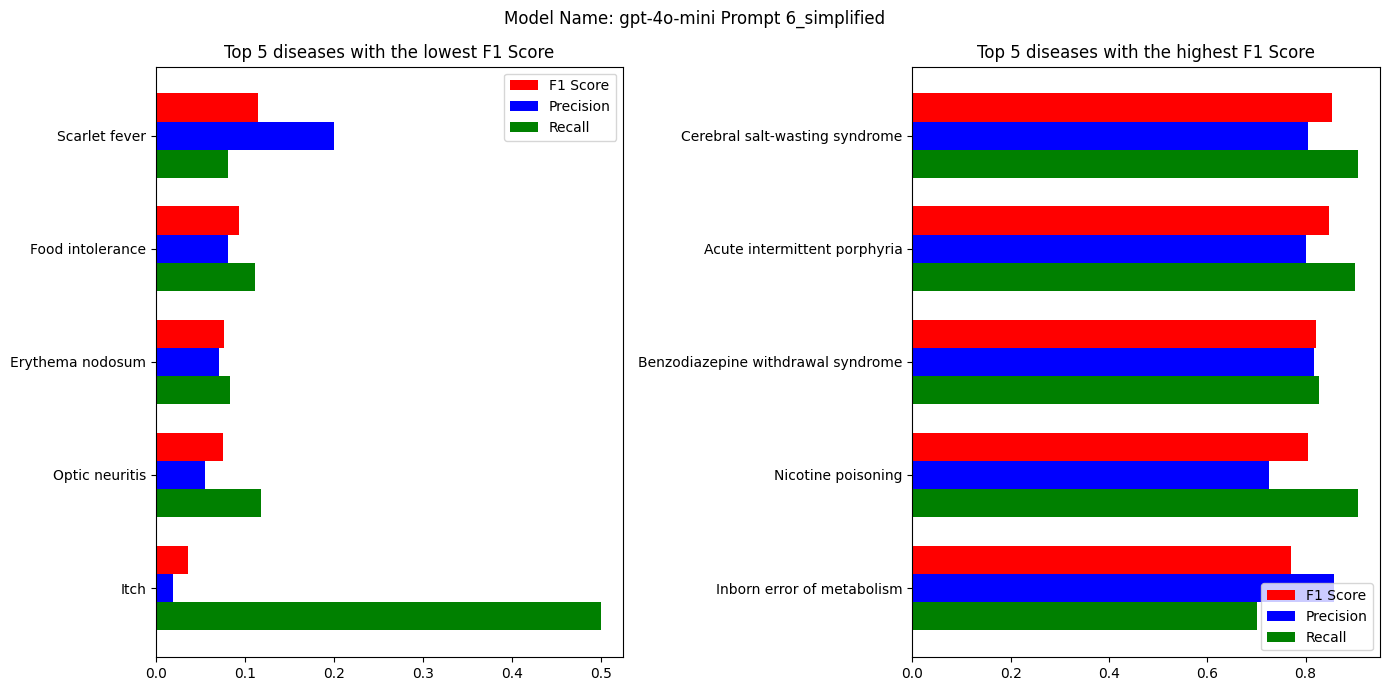

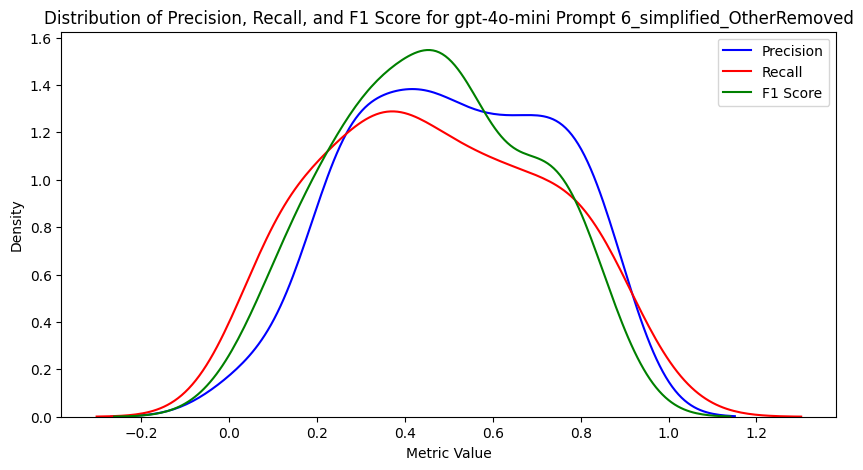

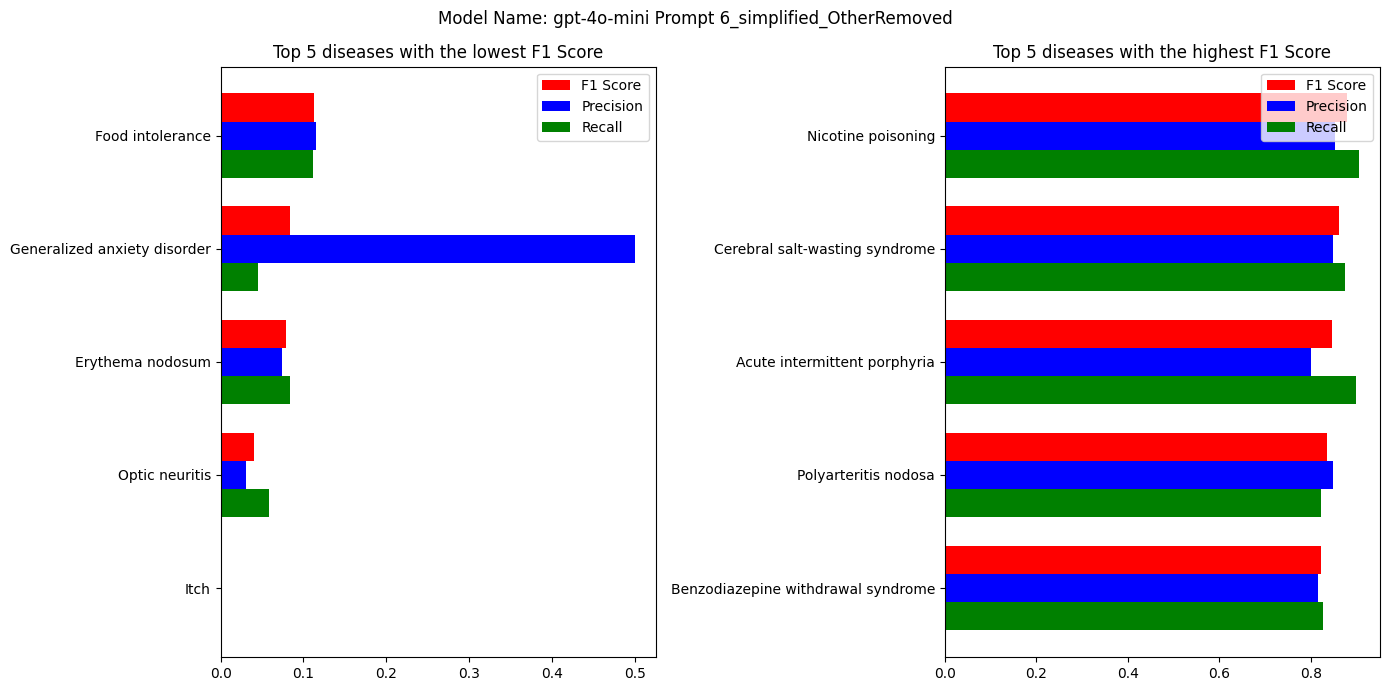

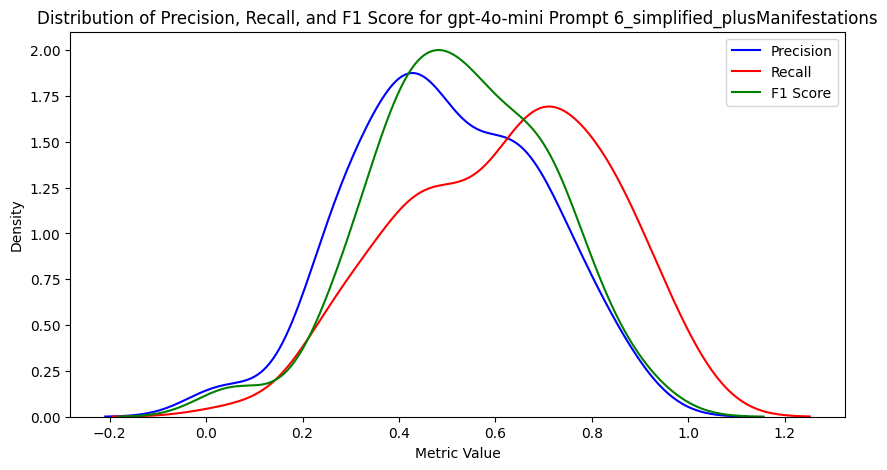

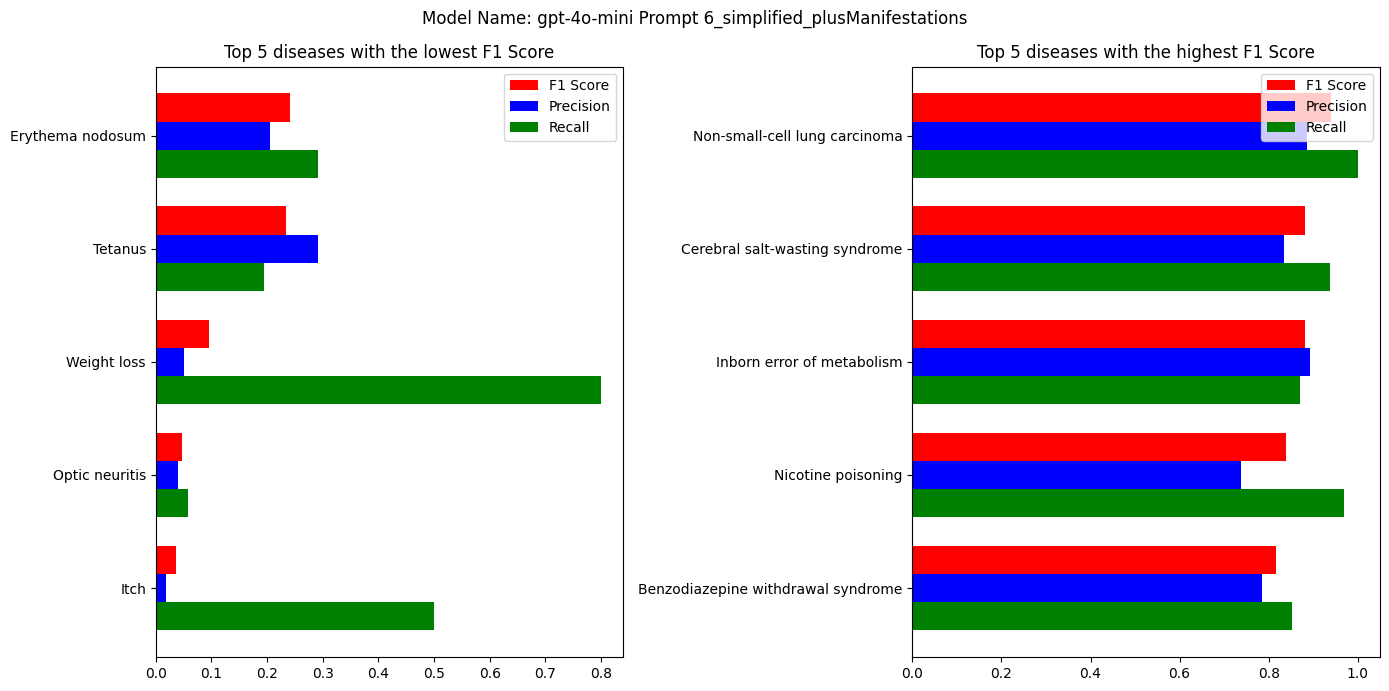

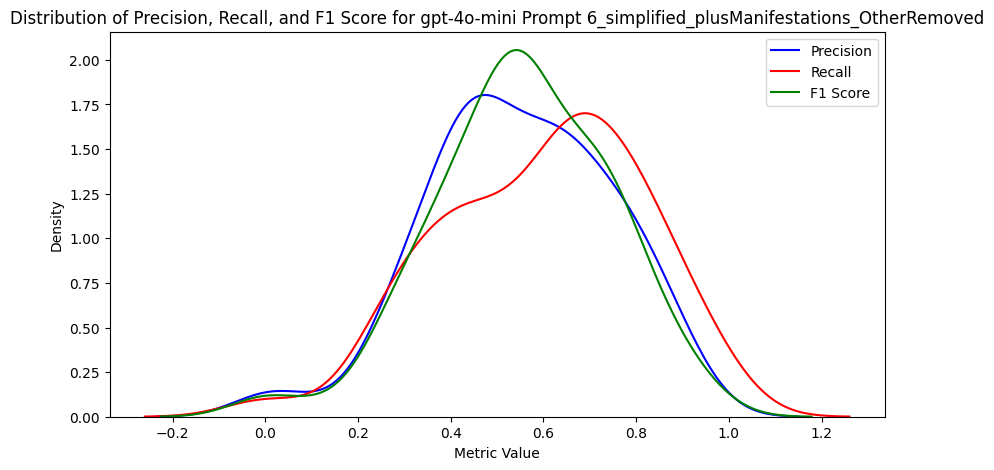

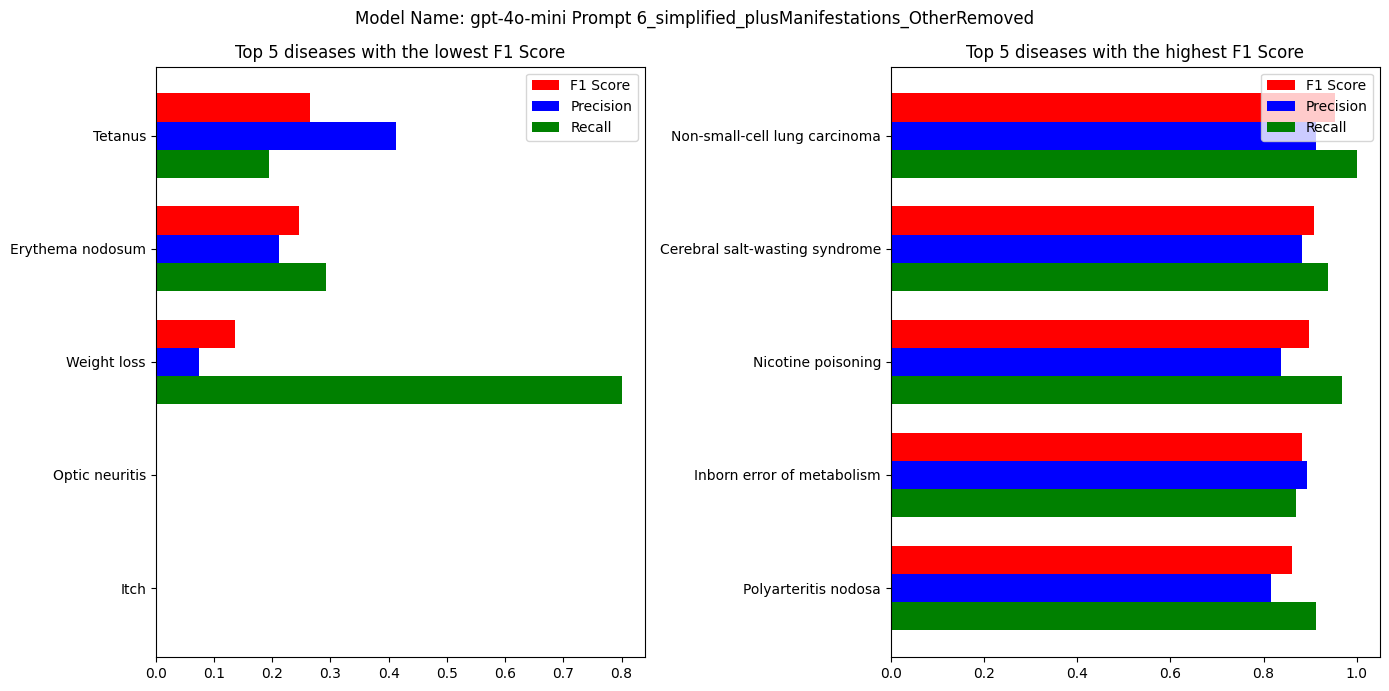

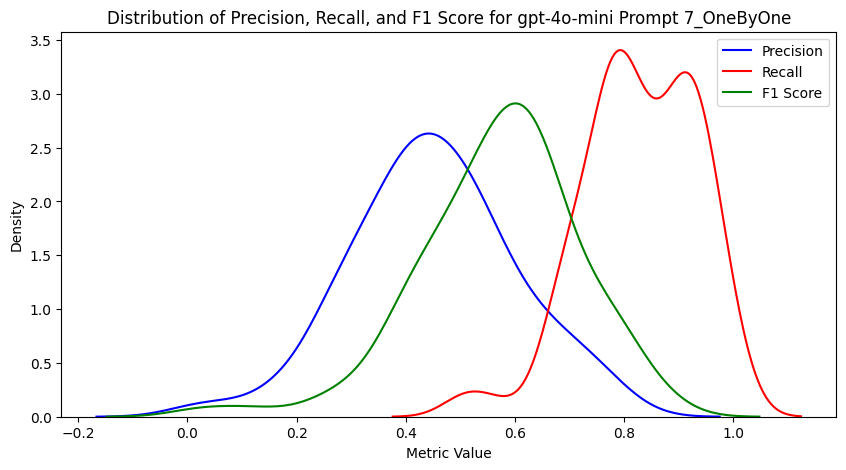

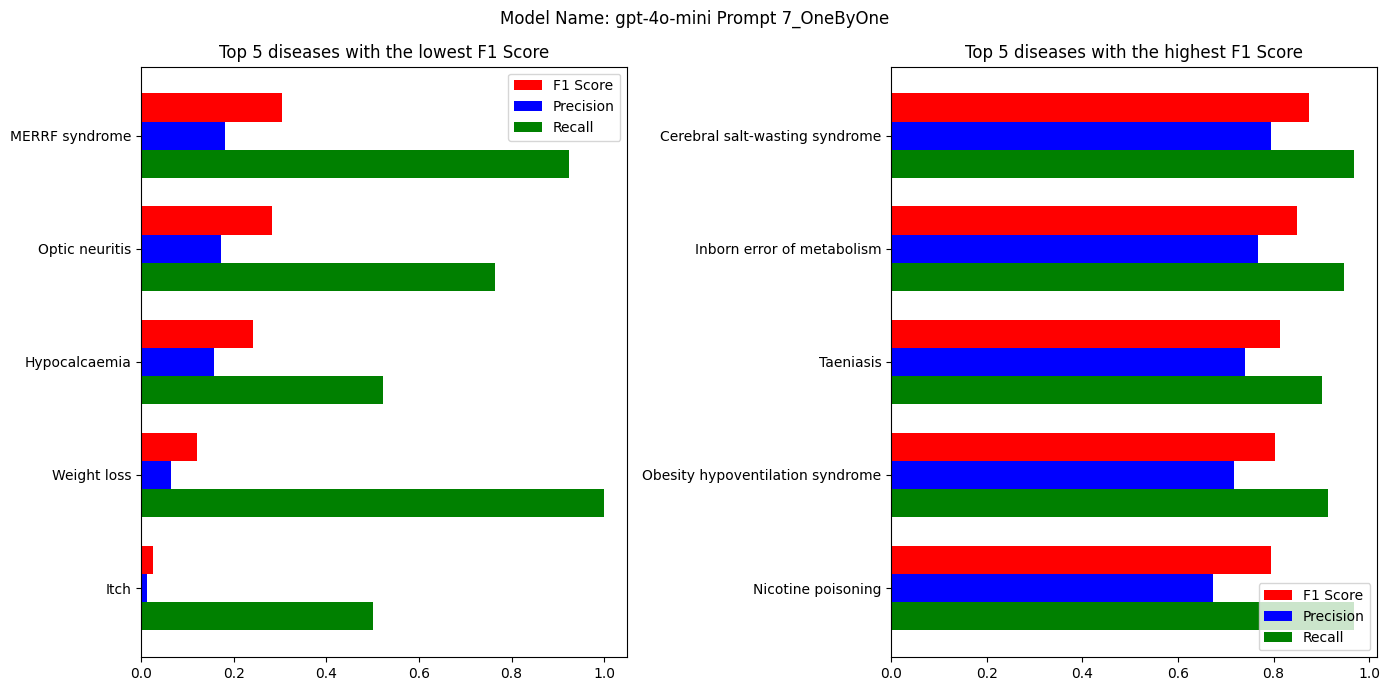

In [11]:
path_to_analyze = r"Validacion de Textos - ChatGPT\Evaluation Files\gpt-4o-mini"
# path_to_model_results = r"Resultados de Prompts\GPT35turbo"
# generate_summary_failed_texts(path_to_model_results)
# analyze_model_results(path_to_model_results)
# calculate_metrics_per_ICD_category(path_to_analyze)
plot_and_print_metrics(path_to_analyze)